In [284]:
import pandas as pd 

import psana as ps
import numpy as np
import math 
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
import h5py
import scipy.stats as st
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter as gf
from sklearn.utils import resample
sys.path.append('/cds/home/d/dgarratt/Code2020/modules')
from chemRIXSAnalysis import *

import matplotlib
font = {'size'   : 16}

matplotlib.rc('font', **font)
cmap = plt.cm.get_cmap('terrain').reversed()

In [285]:
runs = [61]
preproc_folder = '/reg/data/ana16/rix/rixlw1019/results/preproc/v2'
preproc_prefix = 'run'
preproc_suffix = '_v2_part0.h5'

run = runs[0]
preproc_sp = os.path.join(preproc_folder,'{:}{:}{:}'.format(preproc_prefix,run,preproc_suffix))
raw = h5py.File(preproc_sp,'r')
#print(raw.keys())
xgmd = np.array(raw['xgmd_energy'])
gmd = np.array(raw['gmd_energy'])

fim0_raw = np.array(raw['fim0_raw'])
fim1_raw = np.array(raw['fim1_raw'])
fim2_raw = np.array(raw['fim2_raw'])
mono_encoder = np.array(raw['mono_encoder'])
andor_raw = np.array(raw['andor'])
pitch_raw = np.array(raw['epics_MONO_GRATING_PITCH'])
horz_raw = np.array(raw['epics_MR3K4_pitch'])
evrs = np.array(raw['evrs'])
pitch_raw = pitch_raw - 1.607501e5
delay = np.array(raw['epics_LAS_VIT_TIME'])


for run in runs[1:]:
    preproc_sp = os.path.join(preproc_folder,'{:}{:}{:}'.format(preproc_prefix,run,preproc_suffix))
    raw = h5py.File(preproc_sp,'r')
    
    fim0_raw = np.concatenate((fim0_raw,np.array(raw['fim0_raw'])))
    fim1_raw = np.concatenate((fim1_raw,np.array(raw['fim1_raw'])))
    fim2_raw = np.concatenate((fim2_raw,np.array(raw['fim2_raw'])))
    andor_raw = np.concatenate((andor_raw,np.array(raw['andor'])))
    
    delay = np.concatenate((delay, np.array(raw['epics_LAS_VIT_TIME'])))
    
    mono_encoder = np.concatenate((mono_encoder,np.array(raw['mono_encoder'])))
    
    evrs = np.concatenate((evrs,np.array(raw['evrs'])))


msk_pumped = evrs[:,76].astype('bool')
msk_unpumped = evrs[:,77].astype('bool')

#for key in raw.keys():
   # print(key)

In [286]:
evr_bg = 77
bg_msk = evrs[:,evr_bg]==True

fltpos = np.array(raw['ttfex_fltpos'])
atm_los = np.array(raw['atm_lo_x'])
atm_lo_bg = np.average(atm_los[bg_msk,:],axis = 0)

In [287]:
msk = fltpos>1

shots = np.random.randint(0, len(fltpos[msk]),10)
print(shots)

[18373  2483 30927 19771 12209  2118 28100 19199 18131 16389]


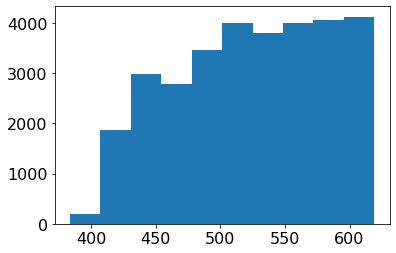

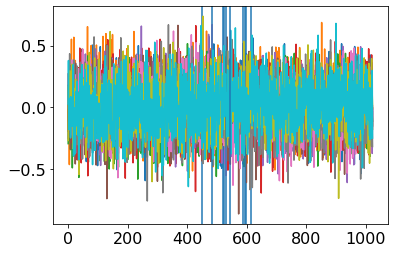

In [288]:
plt.hist(fltpos[msk])
plt.figure()
for s in shots:
    plt.plot(atm_los[msk][s,:]-atm_lo_bg)
    plt.axvline(fltpos[msk][s])

In [289]:
evr_pumped = 77
evr_unpumped = 76
evr_tmp = evrs[500,:]
print(evr_tmp[evr_pumped].astype('bool'))
if evr_tmp[evr_pumped].astype('bool'):
    print('pumped')
elif evr_tmp[evr_unpumped].astype('bool'):
    print('unpumped')
else:
    print('EVR error')

False
unpumped


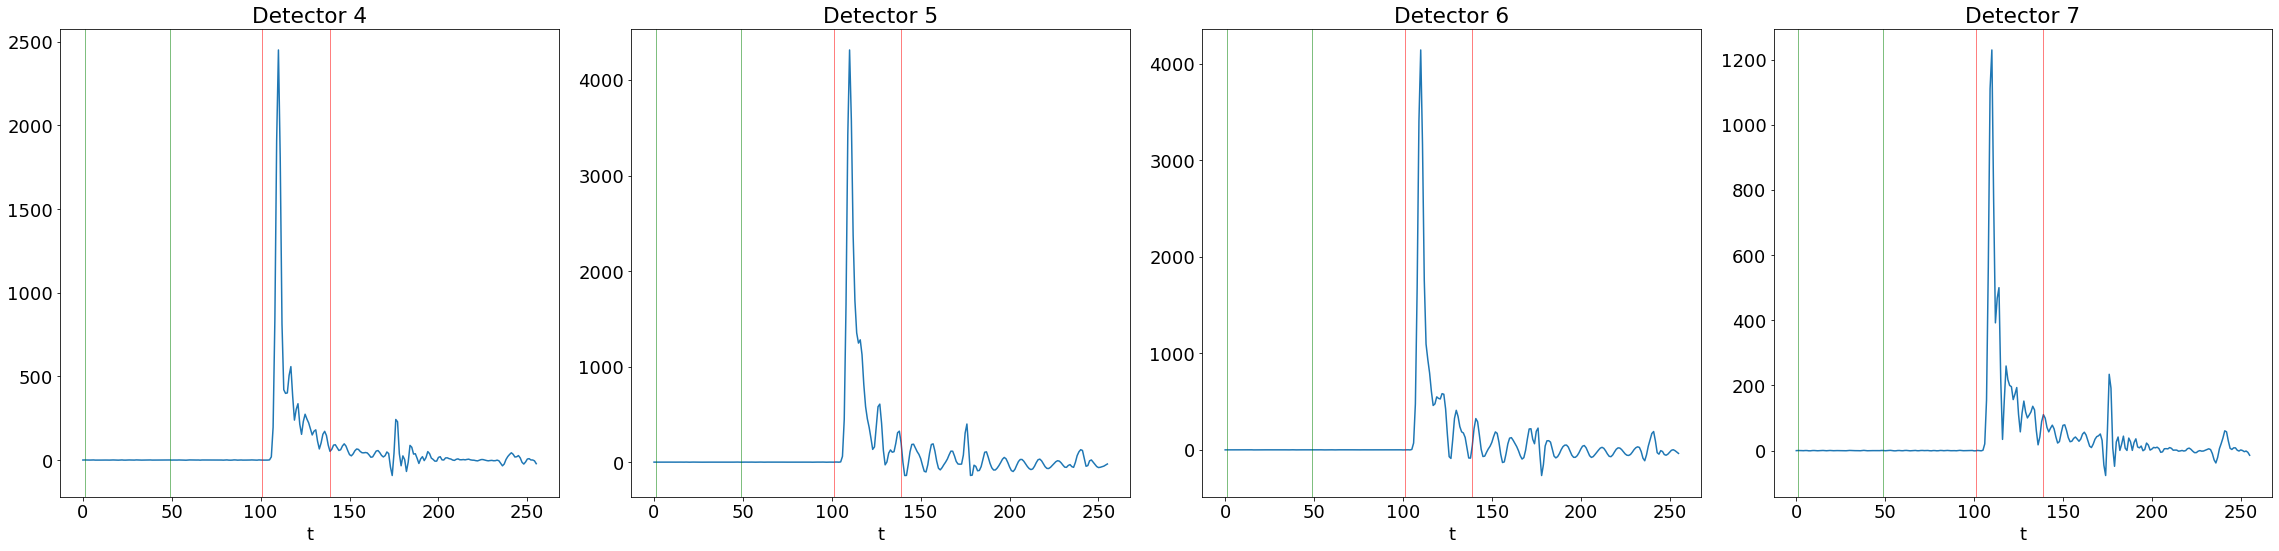

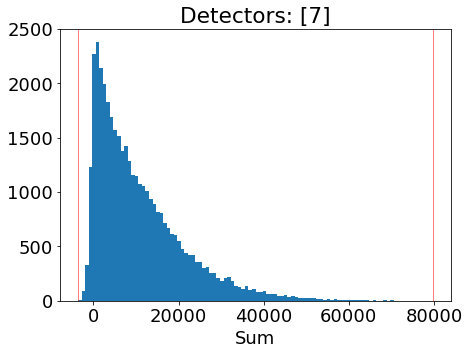

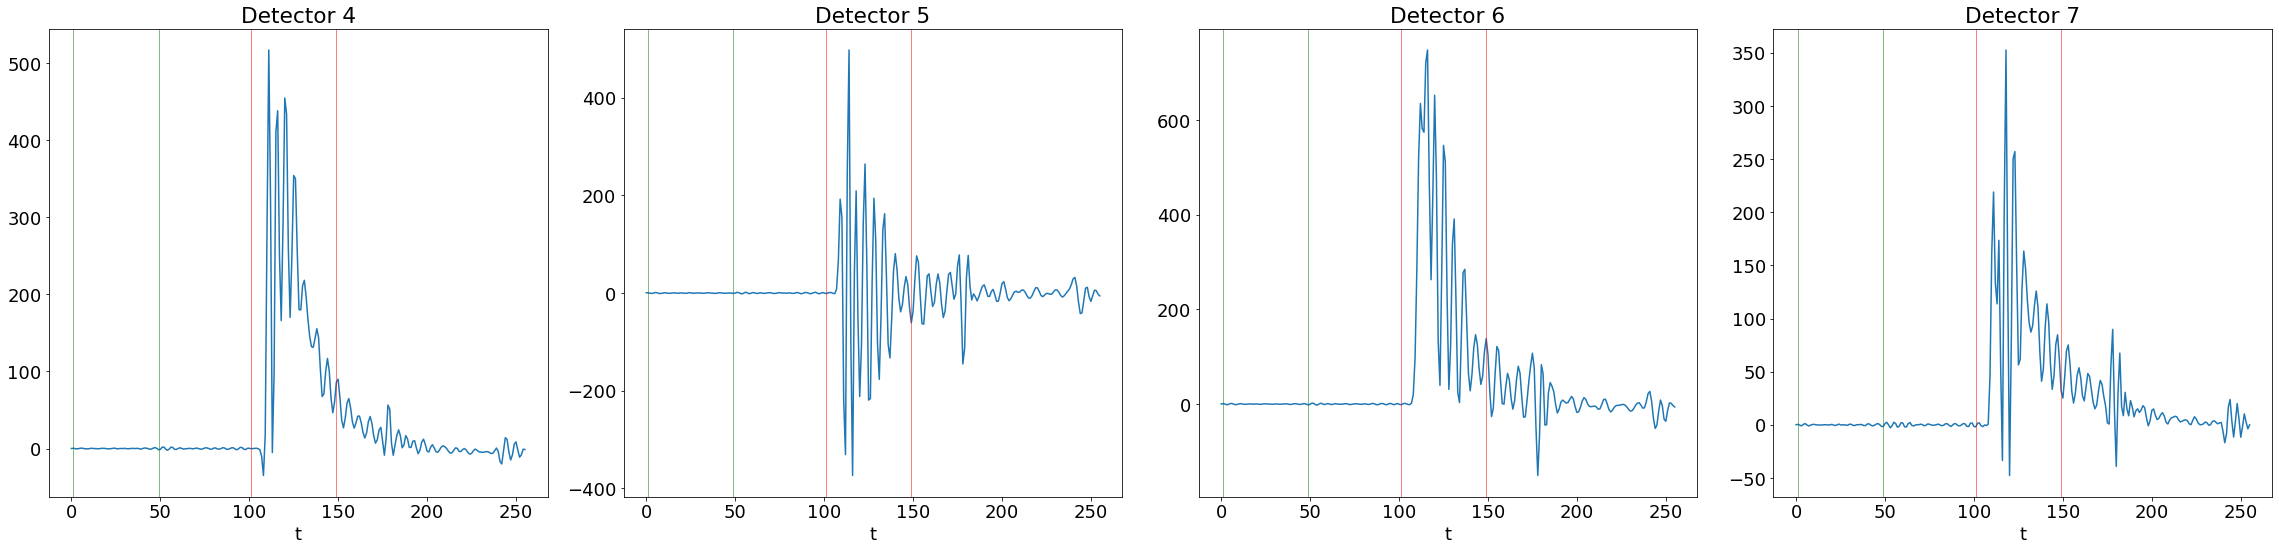

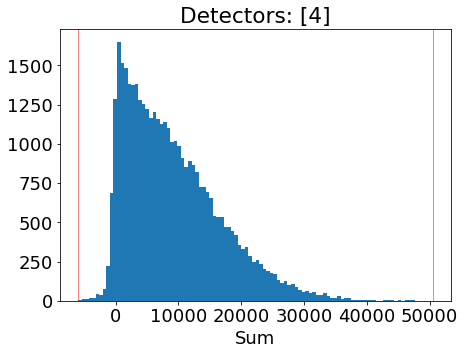

In [294]:
fim0 = fim()
fim0.load_run(fim0_raw)
fim0.set_msk([100,140])
fim0.set_detector_msk([4,5,6,7])
fim0.plot_waveforms(msked = True)
#msk = fim0.I_sum>40000
fim0.set_detector_msk([7])
#fim0.shot_msk = msk
fim0.average_I()
fim0.hist()


fim1 = fim()
fim1.load_run(fim1_raw)
fim1.set_msk([100,150])
fim1.set_detector_msk([4,5,6,7])
#msk = fim1.I_sum>10000
#fim1.shot_msk = msk
fim1.plot_waveforms(msked = True)
fim1.set_detector_msk([4])
fim1.average_I()
fim1.hist()
plt.title('FIM 1, detector 

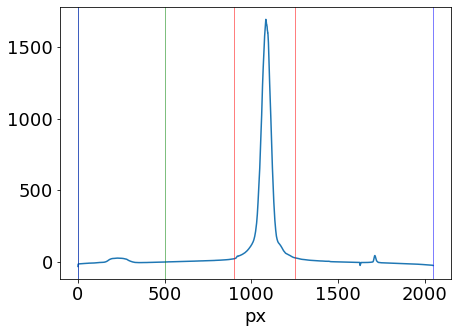

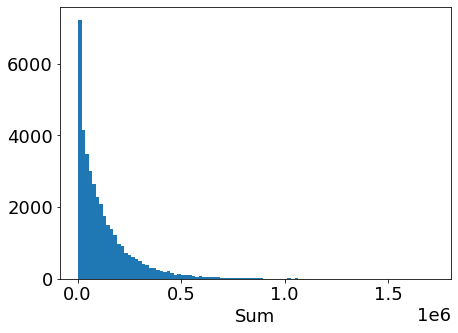

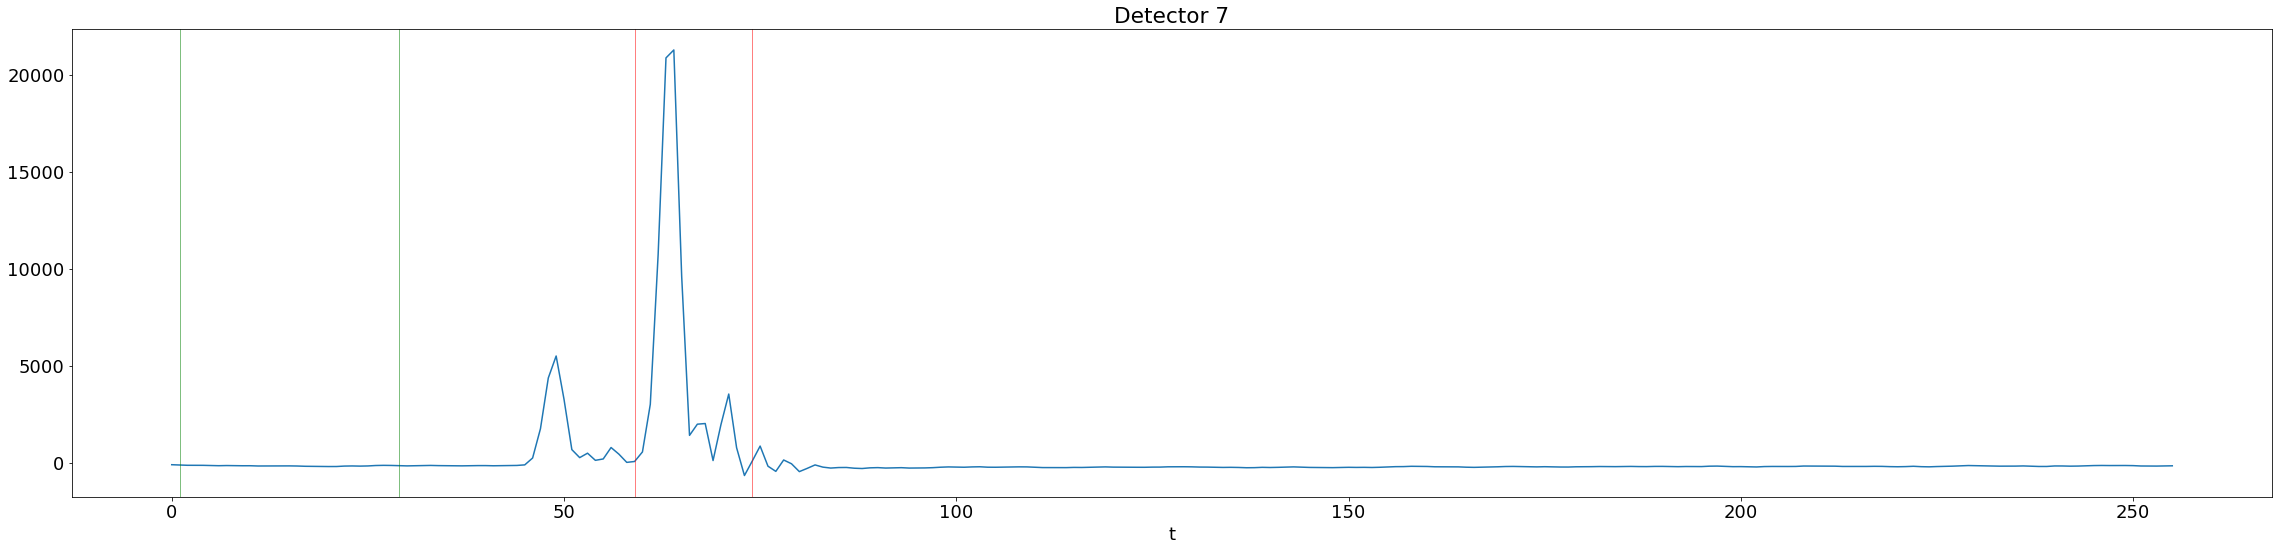

In [295]:
andor_t = andor()
andor_t.set_msk([900,1250])
andor_t.load_run(andor_raw)

andor_t.plot_waveform()
andor_t.hist()


font = {'size'   : 18}
matplotlib.rc('font', **font)
fim2 = fim()
fim2.load_run(fim2_raw[:,:,:])
fim2.set_msk([58,75])
fim2.set_bg_msk([0,30])
fim2.set_detector_msk([7])
#fim2.set_shot_msk(percentile = 95)
fim2.plot_waveforms(msked = True)
fim2.average_I()

0
1
2
3
0


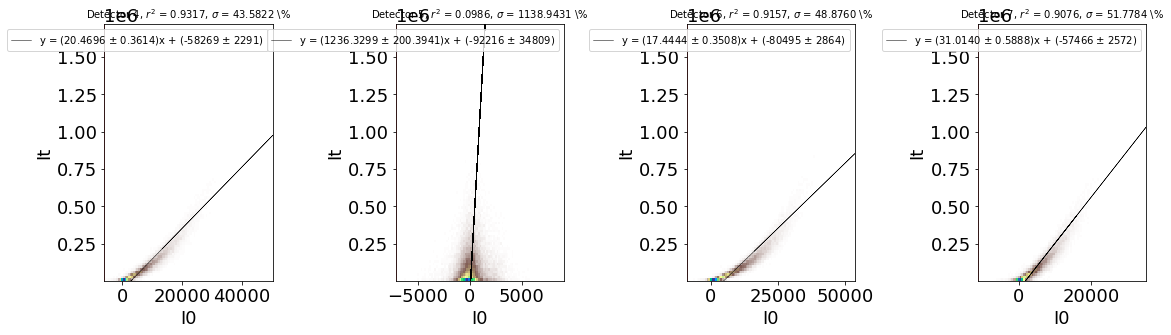

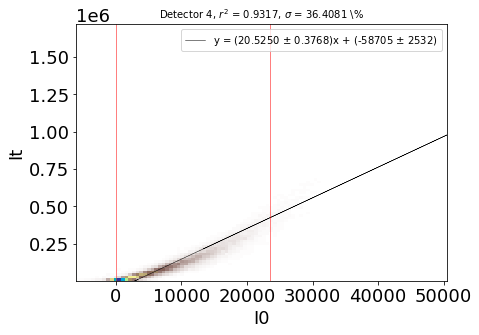

In [292]:
fim1.set_detector_msk([4,5,6,7])
#msk = fim1.I_sum>10000
#fim1.shot_msk = msk
fim1.hist2d_all(andor_t.I_sum,msked = True,figsize = (16,5))

fim1.set_detector_msk([4])
fim1.set_shot_msk(percentile = 95)
#msk = fim1.I_sum>10000
#fim1.shot_msk = msk
fim1.hist2d_all(andor_t.I_sum,msked = True,figsize = (7,5))

#fim1.hist2d_all(fim2.I_sum,msked = True,figsize = (16,5))

/cds/sw/ds/ana/conda2/inst/envs/ps-4.4.3/lib/python3.7/site-packages/ipykernel/__main__.py:454: RuntimeWarning: invalid value encountered in true_divide
/cds/sw/ds/ana/conda2/inst/envs/ps-4.4.3/lib/python3.7/site-packages/ipykernel/__main__.py:421: RuntimeWarning: invalid value encountered in log


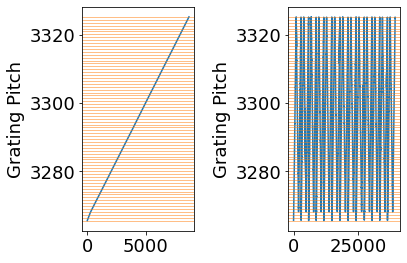

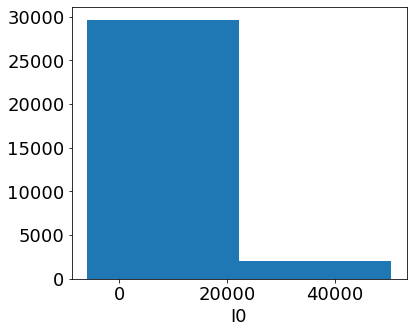

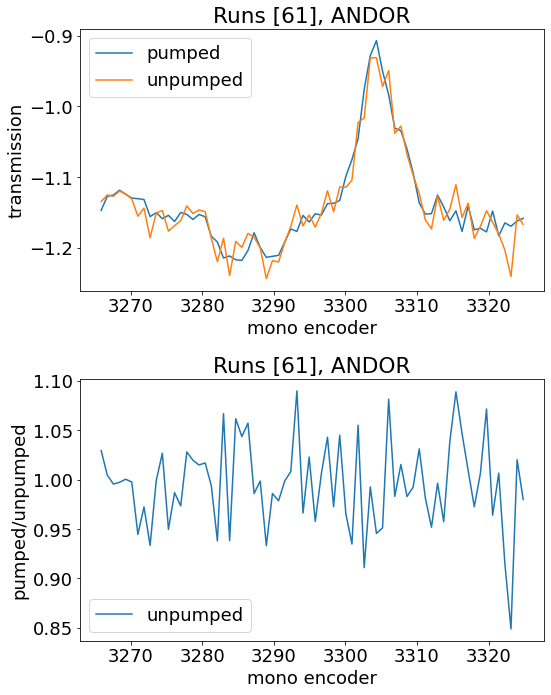

In [297]:
n_encoder_bins = 71
n_I0_bins = 3

#msk=fim0.I_sum>10000
#fim0.shot_msk=msk
#fim0.average_I()
msk = fim1.shot_msk


plt.hist(mono_encoder,bins = 100)
pitch_bins = np.linspace(np.min(mono_encoder),np.max(mono_encoder),n_encoder_bins)
#spec = mono_spectrum(mono_encoder,np.ones(len(fim0.I_sum)),fim2.I_sum,msk = msk)
spec_pumped = mono_spectrum(mono_encoder,fim1.I_sum,andor_t.I_sum,msk = msk&msk_pumped)
spec_unpumped = mono_spectrum(mono_encoder,fim1.I_sum,andor_t.I_sum,msk = msk&msk_unpumped)


spec_pumped.set_pitch_bins(pitch_bins)
spec_unpumped.set_pitch_bins(pitch_bins)
spec_pumped.plot_bins()
I0_bins = np.linspace(np.min(fim1.I_sum[msk]),np.max(fim1.I_sum[msk]),n_I0_bins)
spec_pumped.hist_I0(bins = I0_bins)
spec_pumped.calc_spectrum_mean_binned(I0_bins, count_threshold = 0, bootstrap = False,nrepeat = 20, nsample = 1000,replace = True)
spec_pumped.calc_spectrum_mean()
spec_unpumped.calc_spectrum_mean_binned(I0_bins, count_threshold = 0, bootstrap =False,nrepeat = 20, nsample = 1000,replace = True)
spec_unpumped.calc_spectrum_mean()

#spec.plot_dt(binned=True)
#spec.plot_dt(binned=False)

plt.figure(figsize = (8,10))
plt.subplot(2,1,1)
lt_pumped = np.nansum(spec_pumped.It_binned,axis = 0)/np.nansum(spec_pumped.I0_binned,axis = 0)
lt_unpumped = np.nansum(spec_unpumped.It_binned,axis = 0)/np.nansum(spec_unpumped.I0_binned,axis = 0)

plt.plot(spec_pumped.pitch_bin_centers,-np.log10(lt_pumped),label = 'pumped')
plt.plot(spec_pumped.pitch_bin_centers,-np.log10(lt_unpumped),label = 'unpumped')
#plt.fill_between(spec_pumped.pitch_bin_centers,spec_pumped.transmission-spec_pumped.transmissio
plt.xlabel('mono encoder')
plt.ylabel('transmission')
plt.title('Runs {:}, ANDOR'.format(runs))
plt.legend()

plt.subplot(2,1,2)
#difference = spec_pumped.transmission_binned/spec_unpumped.transmission_binned
difference = lt_pumped/lt_unpumped
#plt.plot(spec_pumped.pitch_bin_centers,spec_pumped.transmission,label = 'pumped')
plt.plot(spec_pumped.pitch_bin_centers,difference,label = 'unpumped')
plt.xlabel('mono encoder')
plt.ylabel('pumped/unpumped')
plt.title('Runs {:}, ANDOR'.format(runs))
plt.legend()
plt.tight_layout()

/cds/sw/ds/ana/conda2/inst/envs/ps-4.4.3/lib/python3.7/site-packages/ipykernel/__main__.py:462: RuntimeWarning: invalid value encountered in log
/cds/sw/ds/ana/conda2/inst/envs/ps-4.4.3/lib/python3.7/site-packages/ipykernel/__main__.py:421: RuntimeWarning: invalid value encountered in log


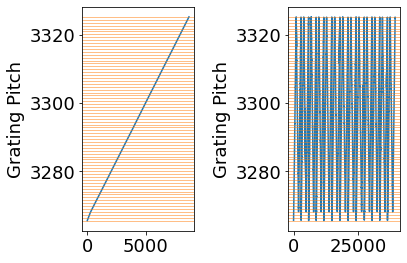

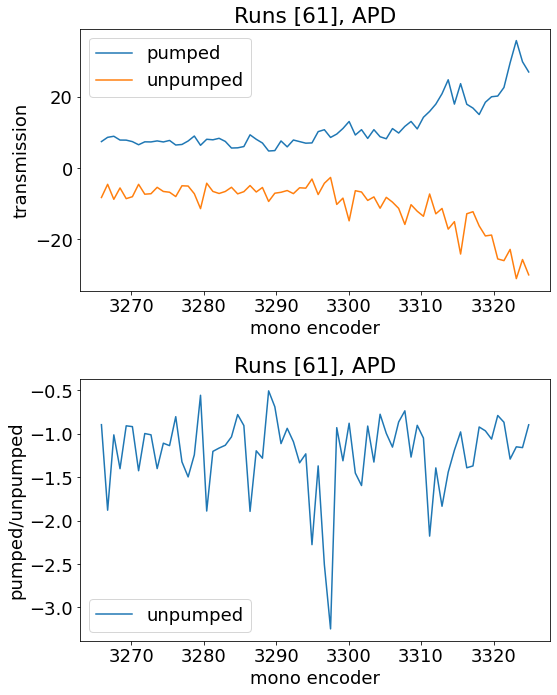

In [282]:
n_encoder_bins = 71
n_I0_bins = 51

#msk=fim0.I_sum>10000
#fim0.shot_msk=msk
#fim0.average_I()
msk = fim1.shot_msk


pitch_bins = np.linspace(np.min(mono_encoder),np.max(mono_encoder),n_encoder_bins)
#spec = mono_spectrum(mono_encoder,np.ones(len(fim0.I_sum)),fim2.I_sum,msk = msk)
spec_pumped = mono_spectrum(mono_encoder,fim1.I_sum,fim2.I_sum,msk = msk&msk_pumped)
spec_unpumped = mono_spectrum(mono_encoder,fim1.I_sum,fim2.I_sum,msk = msk&msk_unpumped)


spec_pumped.set_pitch_bins(pitch_bins)
spec_unpumped.set_pitch_bins(pitch_bins)
spec_pumped.plot_bins()
I0_bins = np.linspace(np.min(fim1.I_sum[msk]),np.max(fim1.I_sum[msk]),n_I0_bins)
#spec_pumped.hist_I0(bins = I0_bins)
spec_pumped.calc_spectrum_mean_binned(I0_bins, count_threshold = 5, bootstrap = False,nrepeat = 20, nsample = 1000,replace = True)
spec_pumped.calc_spectrum_mean()
spec_unpumped.calc_spectrum_mean_binned(I0_bins, count_threshold = 5, bootstrap = False,nrepeat = 20, nsample = 1000,replace = True)
spec_unpumped.calc_spectrum_mean()

#spec.plot_dt(binned=True)
#spec.plot_dt(binned=False)

plt.figure(figsize = (8,10))
plt.subplot(2,1,1)
lt_pumped = np.nansum(spec_pumped.It_binned,axis = 0)/np.nansum(spec_pumped.I0_binned,axis = 0)
lt_unpumped = np.nansum(spec_unpumped.It_binned,axis = 0)/np.nansum(spec_unpumped.I0_binned,axis = 0)

plt.plot(spec_pumped.pitch_bin_centers,lt_pumped,label = 'pumped')
plt.plot(spec_pumped.pitch_bin_centers,lt_unpumped,label = 'unpumped')
plt.xlabel('mono encoder')
plt.ylabel('transmission')
plt.title('Runs {:}, APD'.format(runs))
plt.legend()

plt.subplot(2,1,2)
difference = lt_pumped/lt_unpumped
#plt.plot(spec_pumped.pitch_bin_centers,spec_pumped.transmission,label = 'pumped')
plt.plot(spec_pumped.pitch_bin_centers,difference,label = 'unpumped')
plt.xlabel('mono encoder')
plt.ylabel('pumped/unpumped')
plt.title('Runs {:}, APD'.format(runs))
plt.legend()
plt.tight_layout()

/cds/sw/ds/ana/conda2/inst/envs/ps-4.4.3/lib/python3.7/site-packages/ipykernel/__main__.py:462: RuntimeWarning: invalid value encountered in log


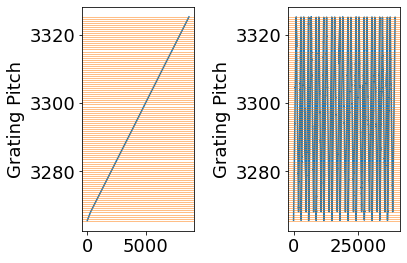

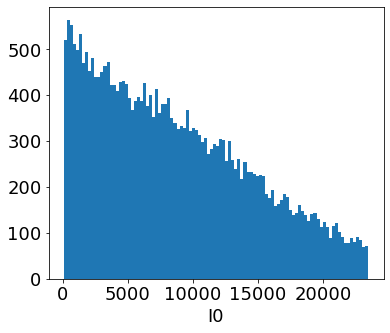

<Figure size 504x360 with 0 Axes>

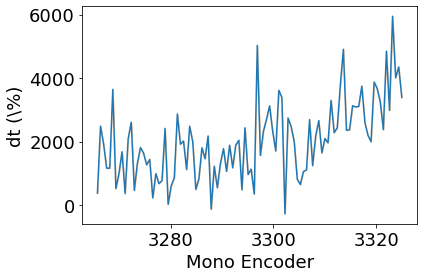

<Figure size 504x360 with 0 Axes>

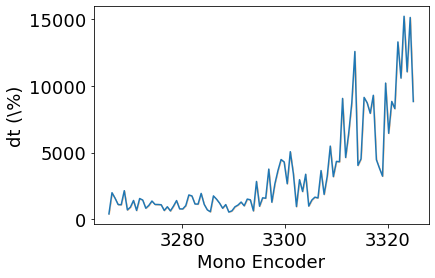

In [187]:
n_encoder_bins = 101
n_I0_bins = 101

#msk=fim0.I_sum>10000
#fim0.shot_msk=msk
#fim0.average_I()
msk = fim1.shot_msk


plt.hist(mono_encoder,bins = 100)
pitch_bins = np.linspace(np.min(mono_encoder),np.max(mono_encoder),n_encoder_bins)
#spec = mono_spectrum(mono_encoder,np.ones(len(fim0.I_sum)),fim2.I_sum,msk = msk)
spec = mono_spectrum(mono_encoder,fim1.I_sum,fim2.I_sum,msk = msk&msk_pumped)
spec.set_pitch_bins(pitch_bins)
spec.plot_bins()
I0_bins = np.linspace(np.min(fim1.I_sum[msk]),np.max(fim1.I_sum[msk]),n_I0_bins)
spec.hist_I0(bins = I0_bins)
spec.calc_spectrum_mean_binned(I0_bins, count_threshold = 5, bootstrap = False,nrepeat = 20, nsample = 1000,replace = True)
spec.calc_spectrum_mean()

spec.plot_dt(binned=True)
spec.plot_dt(binned=False)

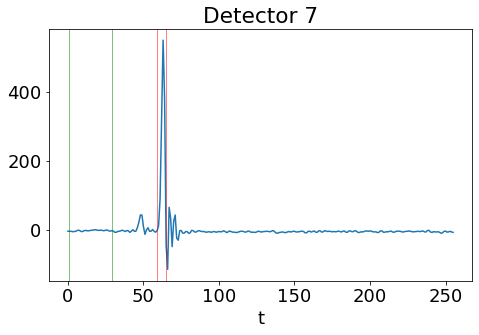

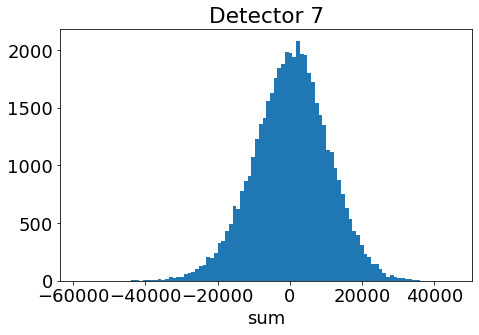

In [149]:
fim2.plot_waveforms(msked = True,figsize = (7,5))
fim2.hist_all(msked = True,figsize = (7,5))

In [150]:
np.float64(10)

10.0

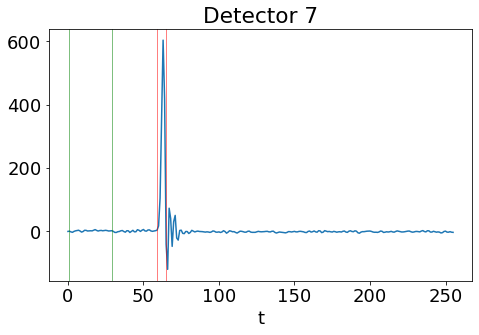

In [152]:
font = {'size'   : 18}
matplotlib.rc('font', **font)
fim2_p = fim()
fim2_p.load_run(fim2_raw[msk_pumped,:,:])
fim2_p.set_msk([58,66])
fim2_p.set_bg_msk([0,30])
fim2_p.set_detector_msk([7])
#fim2.set_shot_msk(percentile = 95)
fim2_p.average_I()
fim2_p.plot_waveforms(msked = True,figsize = (7,5))


0
1
0
1


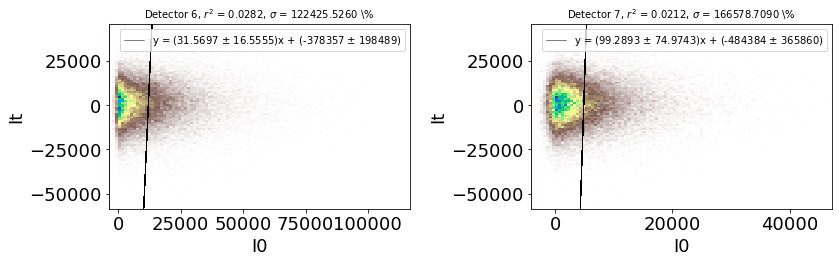

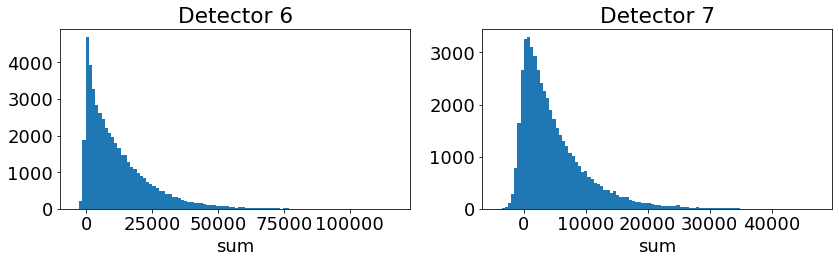

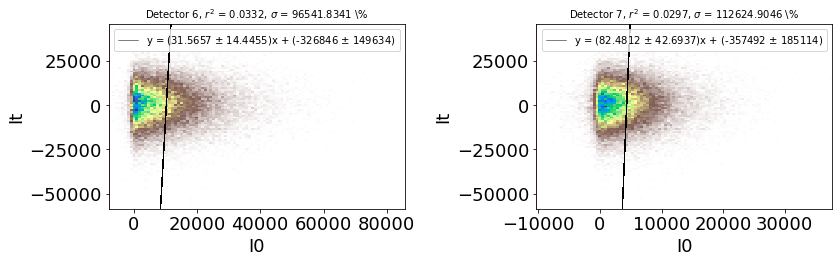

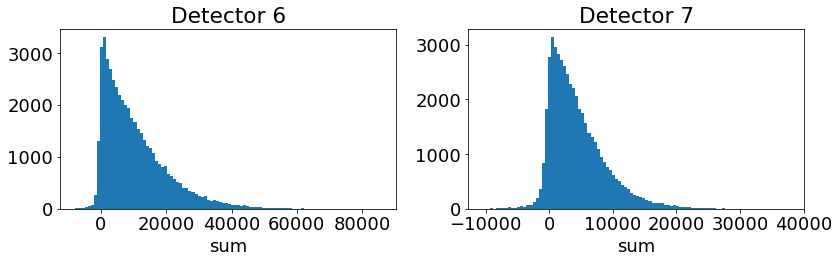

In [153]:
fim0.set_detector_msk([6,7])
fim0.hist2d_all(fim2.I_sum,msked = True,figsize = (12,4))
fim0.hist_all(msked=True,figsize = (12,4))
fim1.set_detector_msk([6,7])


fim1.hist2d_all(fim2.I_sum,msked = True,figsize = (12,4))
fim1.hist_all(msked=True,figsize = (12,4))



/cds/sw/ds/ana/conda2/inst/envs/ps-4.4.3/lib/python3.7/site-packages/ipykernel/__main__.py:462: RuntimeWarning: invalid value encountered in log
/cds/sw/ds/ana/conda2/inst/envs/ps-4.4.3/lib/python3.7/site-packages/ipykernel/__main__.py:421: RuntimeWarning: invalid value encountered in log


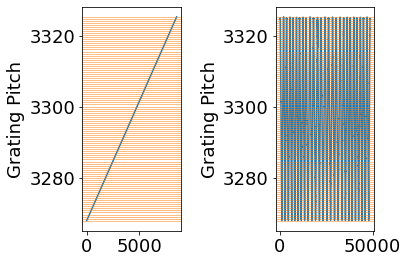

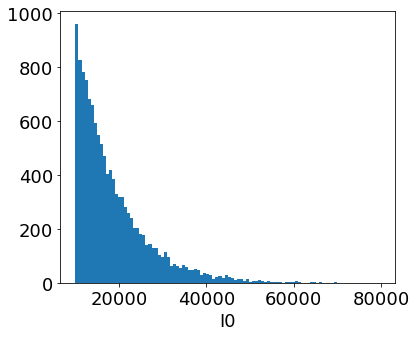

<Figure size 504x360 with 0 Axes>

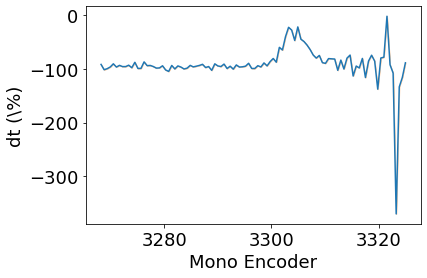

<Figure size 504x360 with 0 Axes>

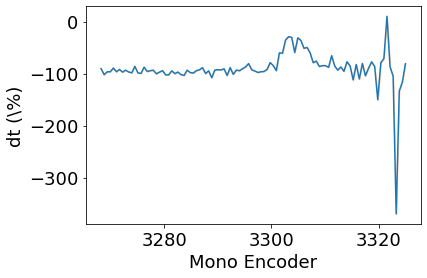

In [154]:
n_encoder_bins = 101
n_I0_bins = 101

#msk=fim0.I_sum>10000
#fim0.shot_msk=msk
#fim0.average_I()

plt.hist(mono_encoder,bins = 100)
pitch_bins = np.linspace(np.min(mono_encoder),np.max(mono_encoder),n_encoder_bins)
#spec = mono_spectrum(mono_encoder,np.ones(len(fim0.I_sum)),fim2.I_sum,msk = msk)
spec = mono_spectrum(mono_encoder,fim0.I_sum,fim2.I_sum,msk = msk&msk_pumped)
spec.set_pitch_bins(pitch_bins)
spec.plot_bins()
I0_bins = np.linspace(np.min(fim0.I_sum[msk]),np.max(fim0.I_sum[msk]),n_I0_bins)
spec.hist_I0(bins = I0_bins)
spec.calc_spectrum_mean_binned(I0_bins, count_threshold = 5, bootstrap = False,nrepeat = 20, nsample = 1000,replace = True)
spec.calc_spectrum_mean()

spec.plot_dt(binned=True)
spec.plot_dt(binned=False)


/cds/sw/ds/ana/conda2/inst/envs/ps-4.4.3/lib/python3.7/site-packages/ipykernel/__main__.py:462: RuntimeWarning: invalid value encountered in log
/cds/sw/ds/ana/conda2/inst/envs/ps-4.4.3/lib/python3.7/site-packages/ipykernel/__main__.py:421: RuntimeWarning: invalid value encountered in log


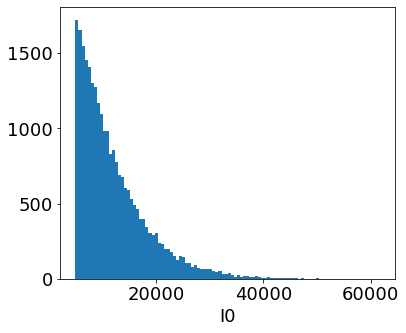

<Figure size 504x360 with 0 Axes>

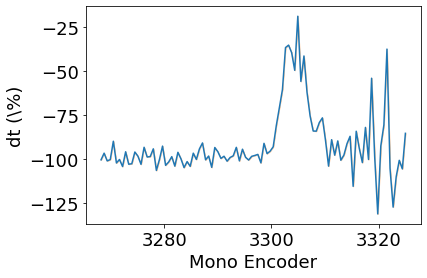

<Figure size 504x360 with 0 Axes>

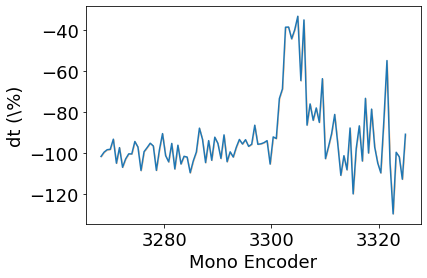

In [155]:
#msk=(fim1.I_sum>5000)
#fim0.shot_msk=msk
#fim0.average_I()
spec = mono_spectrum(mono_encoder,fim1.I_sum,fim2.I_sum,msk = msk)
spec.set_pitch_bins(pitch_bins)
I0_bins = np.linspace(np.min(fim1.I_sum[msk]),np.max(fim1.I_sum[msk]),n_I0_bins)
spec.hist_I0(bins = I0_bins)
spec.calc_spectrum_mean_binned(I0_bins, count_threshold = 1, bootstrap = False,nrepeat = 20, nsample = 1000,replace = True)
spec.calc_spectrum_mean()

spec.plot_dt(binned=True)
spec.plot_dt(binned=False)

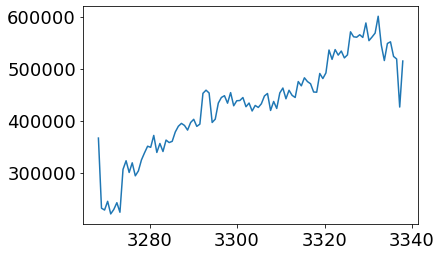

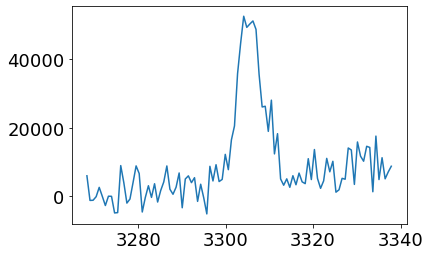

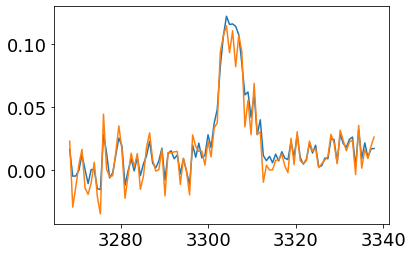

In [60]:

It = np.nanmean(spec.It_binned,axis = 0)
I0 = np.nanmean(spec.I0_binned,axis = 0)
E = spec.pitch_bin_centers
plt.figure()
plt.plot(E,I0)
plt.figure()
plt.plot(E,It)
plt.figure()
plt.plot(E,It/I0)
plt.plot(E,spec.transmission)

/cds/sw/ds/ana/conda2/inst/envs/ps-4.4.3/lib/python3.7/site-packages/ipykernel/__main__.py:421: RuntimeWarning: invalid value encountered in log


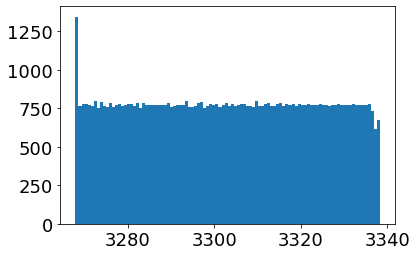

<Figure size 504x360 with 0 Axes>

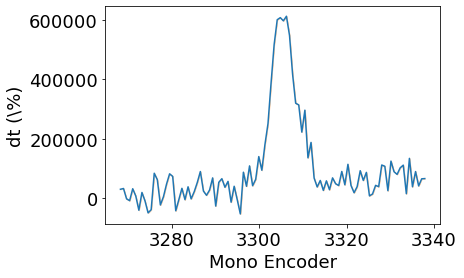

In [61]:
msk_fim0=fim0.I_sum>50000
fim0.shot_msk=msk
fim0.average_I()

plt.hist(mono_encoder,bins = 100)
spec = mono_spectrum(mono_encoder,np.ones(len(fim0.I_sum)),fim2.I_sum,msk = msk_fim0)
spec.set_pitch_bins(pitch_bins)
spec.calc_spectrum_mean()

spec.plot_dt(binned=False)

/cds/sw/ds/ana/conda2/inst/envs/ps-4.4.3/lib/python3.7/site-packages/ipykernel/__main__.py:421: RuntimeWarning: invalid value encountered in log


[0.07889279 0.0827251  0.12178413 0.12916614 0.11360618 0.14270254
 0.13912863 0.09732705 0.09141362 0.08145595 0.06802408 0.10784298
 0.11884288 0.08332291 0.08463815 0.05321873 0.11378927 0.0844103
 0.0904291  0.05368885 0.0982139  0.07088425 0.08072202 0.09871754
 0.07150802 0.06732461 0.08123739 0.08860293 0.06834142 0.07943178
 0.06377399 0.06552886 0.07609741 0.0745872  0.04837418 0.05867674
 0.05738666 0.10016973 0.07543692 0.06070854 0.07933003 0.07152415
 0.06045556 0.08464606 0.09958097 0.06337542 0.06946711 0.06443092
 0.05415817 0.07135011 0.07037743 0.08958162 0.08040325 0.0814851
 0.08226979 0.08836166 0.06245397 0.08408408 0.07125442 0.05710619
 0.04512523 0.06654499 0.07336827 0.06118303 0.07303201 0.05952668
 0.06342651 0.06620667 0.06036538 0.06053537 0.0565713  0.07627033
 0.08157501 0.05711418 0.05369903 0.05211404 0.06981672 0.06181431
 0.05436174 0.0583903  0.06568051 0.0603487  0.05486105 0.05361094
 0.04359093 0.0558651  0.04179922 0.06115105 0.04068806 0.064752

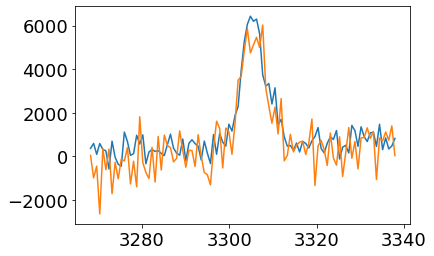

In [62]:


spec_pumped = mono_spectrum(mono_encoder,np.ones(len(fim0.I_sum)),fim2.I_sum,msk = msk_fim0&msk_pumped)
spec_pumped.set_pitch_bins(pitch_bins)
spec_pumped.calc_spectrum_mean()

spec_unpumped = mono_spectrum(mono_encoder,np.ones(len(fim0.I_sum)),fim2.I_sum,msk = msk_fim0&msk_unpumped)
spec_unpumped.set_pitch_bins(pitch_bins)
spec_unpumped.calc_spectrum_mean()

#spec_pumped.plot_dt(binned=False)
#spec_unpumped.plot_dt(binned=False)

plt.figure()
plt.plot(spec_pumped.pitch_bin_centers,spec_pumped.transmission)
plt.plot(spec_pumped.pitch_bin_centers,spec_unpumped.transmission)
print(spec_pumped.transmission_err)

In [ ]:
runs = [641]
preproc_folder = '/reg/data/ana16/rix/rixx43518/scratch/preproc/v1'
preproc_prefix = 'run'
preproc_suffix = '_v1_part0.h5'

run = runs[0]
preproc_sp = os.path.join(preproc_folder,'{:}{:}{:}'.format(preproc_prefix,run,preproc_suffix))
raw = h5py.File(preproc_sp,'r')
#print(raw.keys())
xgmd = np.array(raw['xgmd_energy'])
gmd = np.array(raw['gmd_energy'])

fim0_raw = np.array(raw['fim0_raw'])
fim1_raw = np.array(raw['fim1_raw'])
fim2_raw = np.array(raw['fim2_raw'])
mono_encoder = np.array(raw['mono_encoder'])
#andor_raw = np.array(raw['andor'])
pitch_raw = np.array(raw['epics_MONO_GRATING_PITCH'])
horz_raw = np.array(raw['epics_MR3K4_pitch'])
evrs = np.array(raw['evrs'])
pitch_raw = pitch_raw - 1.607501e5


msk_pumped = evrs[:,76].astype('bool')
msk_unpumped = evrs[:,77].astype('bool')

fim0 = fim()
fim0.load_run(fim0_raw)
fim0.set_msk([100,140])
fim0.set_detector_msk([4,5,6,7])
msk_fim0 = fim0.I_sum>40000
fim0.shot_msk = msk_fim0
fim0.average_I()
#fim0.plot_waveforms(msked = True)
#fim0.hist()


fim1 = fim()
fim1.load_run(fim1_raw)
fim1.set_msk([100,140])
fim1.set_detector_msk([4,5,6,7])
msk_fim1 = fim1.I_sum>10000
fim1.shot_msk = msk_fim1
fim1.average_I()
#fim0.plot_waveforms(msked = True)
#fim1.hist()

font = {'size'   : 18}
matplotlib.rc('font', **font)
fim2 = fim()
fim2.load_run(fim2_raw[:,:,:])
fim2.set_msk([58,70])
fim2.set_bg_msk([0,30])
fim2.set_detector_msk([4])
#fim2.set_shot_msk(percentile = 95)
fim2.average_I()
fim2.plot_waveforms(msked=True,figsize = (6,4))
plt.xlim(0,200)
plt.title('Run {:} average photodiode trace'.format(run))
plt.grid()
fim2.set_detector_msk([7])
#fim2.set_shot_msk(percentile = 95)
fim2.average_I()
fim2.plot_waveforms(msked=True,figsize = (6,4))
plt.xlim(0,100)


spec_pumped = mono_spectrum(mono_encoder,np.ones(len(fim0.I_sum)),fim2.I_sum,msk = msk_fim0&msk_pumped)
spec_pumped.set_pitch_bins(pitch_bins)
spec_pumped.calc_spectrum_mean()

spec_unpumped = mono_spectrum(mono_encoder,np.ones(len(fim0.I_sum)),fim2.I_sum,msk = msk_fim0&msk_unpumped)
spec_unpumped.set_pitch_bins(pitch_bins)
spec_unpumped.calc_spectrum_mean()

#spec_pumped.plot_dt(binned=False)
#spec_unpumped.plot_dt(binned=False)

plt.figure()
plt.plot(spec_pumped.pitch_bin_centers,spec_pumped.transmission,label = 'pumped')
plt.plot(spec_pumped.pitch_bin_centers,spec_unpumped.transmission,label = 'unpumped')
plt.legend()


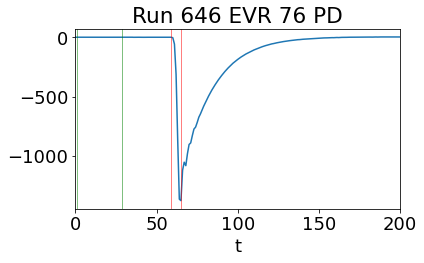

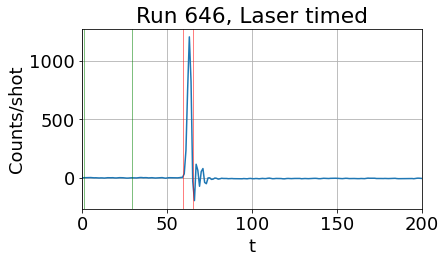

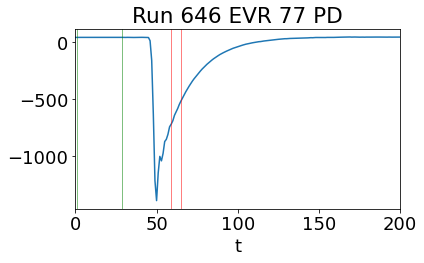

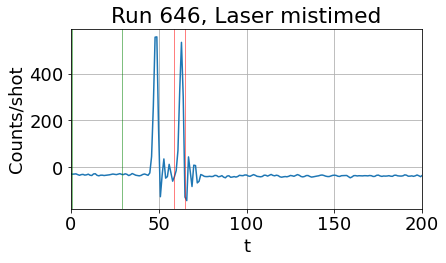

In [15]:
runs = [646]
preproc_folder = '/reg/data/ana16/rix/rixx43518/scratch/preproc/v1'
preproc_prefix = 'run'
preproc_suffix = '_v1_part0.h5'

run = runs[0]
preproc_sp = os.path.join(preproc_folder,'{:}{:}{:}'.format(preproc_prefix,run,preproc_suffix))
raw = h5py.File(preproc_sp,'r')
#print(raw.keys())
xgmd = np.array(raw['xgmd_energy'])
gmd = np.array(raw['gmd_energy'])

fim0_raw = np.array(raw['fim0_raw'])
fim1_raw = np.array(raw['fim1_raw'])
fim2_raw = np.array(raw['fim2_raw'])
mono_encoder = np.array(raw['mono_encoder'])
#andor_raw = np.array(raw['andor'])
pitch_raw = np.array(raw['epics_MONO_GRATING_PITCH'])
horz_raw = np.array(raw['epics_MR3K4_pitch'])
evrs = np.array(raw['evrs'])
pitch_raw = pitch_raw - 1.607501e5

msk_pumped = evrs[:,76].astype('bool')
msk_unpumped = evrs[:,77].astype('bool')

fim2_p = fim()
fim2_p.load_run(fim2_raw[msk_pumped,:,:])
fim2_p.set_bg_msk([0,30])
fim2_p.set_msk([58,66])
fim2_p.set_detector_msk([4])
fim2_p.plot_waveforms(msked=True,figsize = (6,4))
plt.xlim(0,200)
plt.title('Run {:} EVR 76 PD'.format(run))
fim2_p.set_detector_msk([7])
#fim2.set_shot_msk(percentile = 95)
fim2_p.plot_waveforms(msked=True,figsize = (6,4))
plt.xlim(0,200)
plt.ylabel('Counts/shot')
plt.title('Run {:}, Laser timed'.format(run))
plt.grid()


fim2_up = fim()
fim2_up.load_run(fim2_raw[msk_unpumped,:,:])
fim2_up.set_bg_msk([0,30])
fim2_up.set_msk([58,66])
fim2_up.set_detector_msk([4])
fim2_up.plot_waveforms(msked=True,figsize = (6,4))
plt.xlim(0,200)
plt.title('Run {:} EVR 77 PD'.format(run))
fim2_up.set_detector_msk([7])
#fim2.set_shot_msk(percentile = 95)
fim2_up.plot_waveforms(msked=True,figsize = (6,4))
plt.xlim(0,200)
plt.ylabel('Counts/shot')
plt.title('Run {:}, Laser mistimed'.format(run))
plt.grid()

(77599, 288)


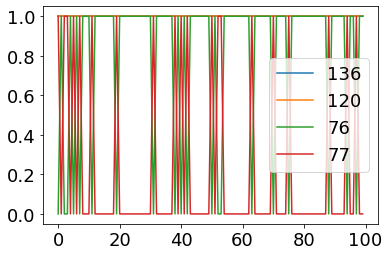

In [322]:
print(evrs.shape)
plt.plot(evrs[:100,136],label = '136')
plt.plot(evrs[:100,120],label = '120')
plt.plot(evrs[:100,76],label = '76')
plt.plot(evrs[:100,77],label = '77')
plt.legend()
    

/cds/sw/ds/ana/conda2/inst/envs/ps-4.4.3/lib/python3.7/site-packages/ipykernel/__main__.py:453: RuntimeWarning: invalid value encountered in log
/cds/sw/ds/ana/conda2/inst/envs/ps-4.4.3/lib/python3.7/site-packages/ipykernel/__main__.py:412: RuntimeWarning: invalid value encountered in log


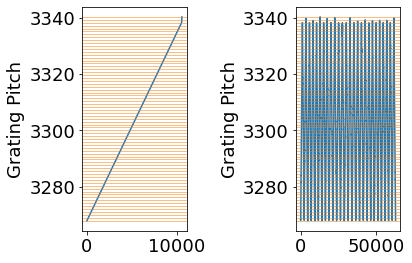

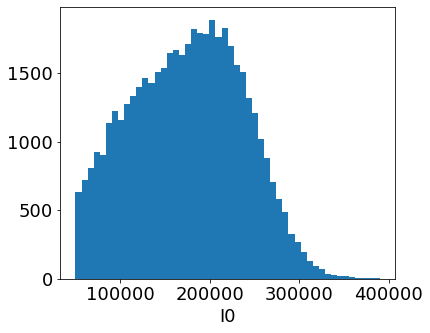

<Figure size 504x360 with 0 Axes>

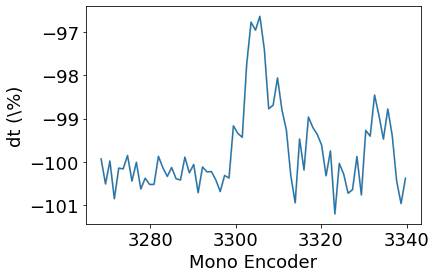

<Figure size 504x360 with 0 Axes>

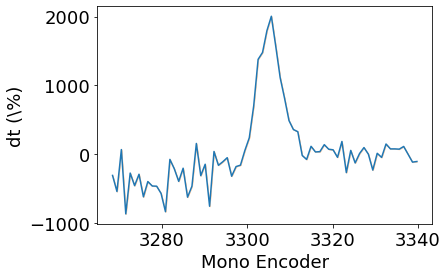

In [296]:
msk=fim0.I_sum>50000
fim0.shot_msk=msk
fim0.average_I()

plt.hist(mono_encoder,bins = 100)
pitch_bins = np.linspace(np.min(mono_encoder),np.max(mono_encoder),71)
#spec = mono_spectrum(mono_encoder,np.ones(len(fim0.I_sum)),fim2.I_sum,msk = msk)
spec = mono_spectrum(mono_encoder,fim0.I_sum,fim2.I_sum,msk = msk)
spec.set_pitch_bins(pitch_bins)
spec.plot_bins()
I0_bins = np.linspace(np.min(fim0.I_sum[msk]),np.max(fim0.I_sum[msk]),51)
spec.hist_I0(bins = I0_bins)
spec.calc_spectrum_mean_binned(I0_bins, count_threshold = 5, bootstrap = False,nrepeat = 20, nsample = 1000,replace = True)
spec.calc_spectrum_mean()

spec.plot_dt(binned=True)
spec.plot_dt(binned=False)

/cds/sw/ds/ana/conda2/inst/envs/ps-4.4.3/lib/python3.7/site-packages/ipykernel/__main__.py:453: RuntimeWarning: invalid value encountered in log
/cds/sw/ds/ana/conda2/inst/envs/ps-4.4.3/lib/python3.7/site-packages/ipykernel/__main__.py:412: RuntimeWarning: invalid value encountered in log


<Figure size 504x360 with 0 Axes>

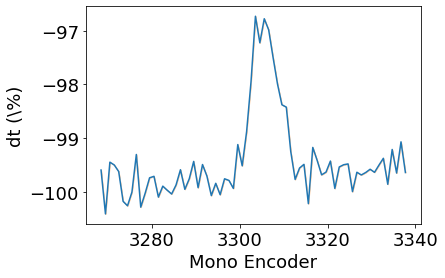

In [214]:
msk=fim0.I_sum>10000
fim0.shot_msk=msk
fim0.average_I()
I0_bins = np.linspace(np.min(fim0.I_sum[msk]),np.max(fim0.I_sum[msk]),151)
spec.calc_spectrum_mean_binned(I0_bins, count_threshold = 1, bootstrap = False,nrepeat = 20, nsample = 1000,replace = True)
spec.calc_spectrum_mean()
spec.plot_dt(binned=True)

In [127]:
for i, dat in enumerate(np.rollaxis(fim0.I_sums[:,fim0.detector_msk],1)):
    print(i)
    print(fim0.indicies[i])

0
4
1
5
2
6
3
7


In [93]:
runs = [457]
preproc_folder = '/reg/data/ana16/rix/rixx43518/scratch/preproc/v1'
preproc_prefix = 'run'
preproc_suffix = '_v1_part0.h5'

run = runs[0]
preproc_sp = os.path.join(preproc_folder,'{:}{:}{:}'.format(preproc_prefix,run,preproc_suffix))
raw = h5py.File(preproc_sp,'r')
#print(raw.keys())
#xgmd = np.array(raw['xgmd_energy'])
#gmd = np.array(raw['gmd_energy'])

fim0_raw = np.array(raw['fim0_raw'])
mono_encoder = np.array(raw['mono_encoder'])
andor_raw = np.array(raw['andor'])
pitch_raw = np.array(raw['epics_MONO_GRATING_PITCH'])
horz_raw = np.array(raw['epics_MR3K4_pitch'])
evrs = np.array(raw['evrs'])
pitch_raw = pitch_raw - 1.607501e5

#for run in runs[1:]:
#    preproc_sp = os.path.join(preproc_folder,'{:}{:}{:}'.format(preproc_prefix,run,preproc_suffix))
#    raw = h5py.File(preproc_sp,'r')
    
#    fim2_raw = np.concatenate((fim2_raw,np.array(raw['fim2_raw'])))
#    mono_encoder = np.concatenate((mono_encoder,np.array(raw['mono_encoder'])))

print(andor_raw.shape)
print(fim0_raw.shape)

(3318, 2048)
(3318, 8, 256)


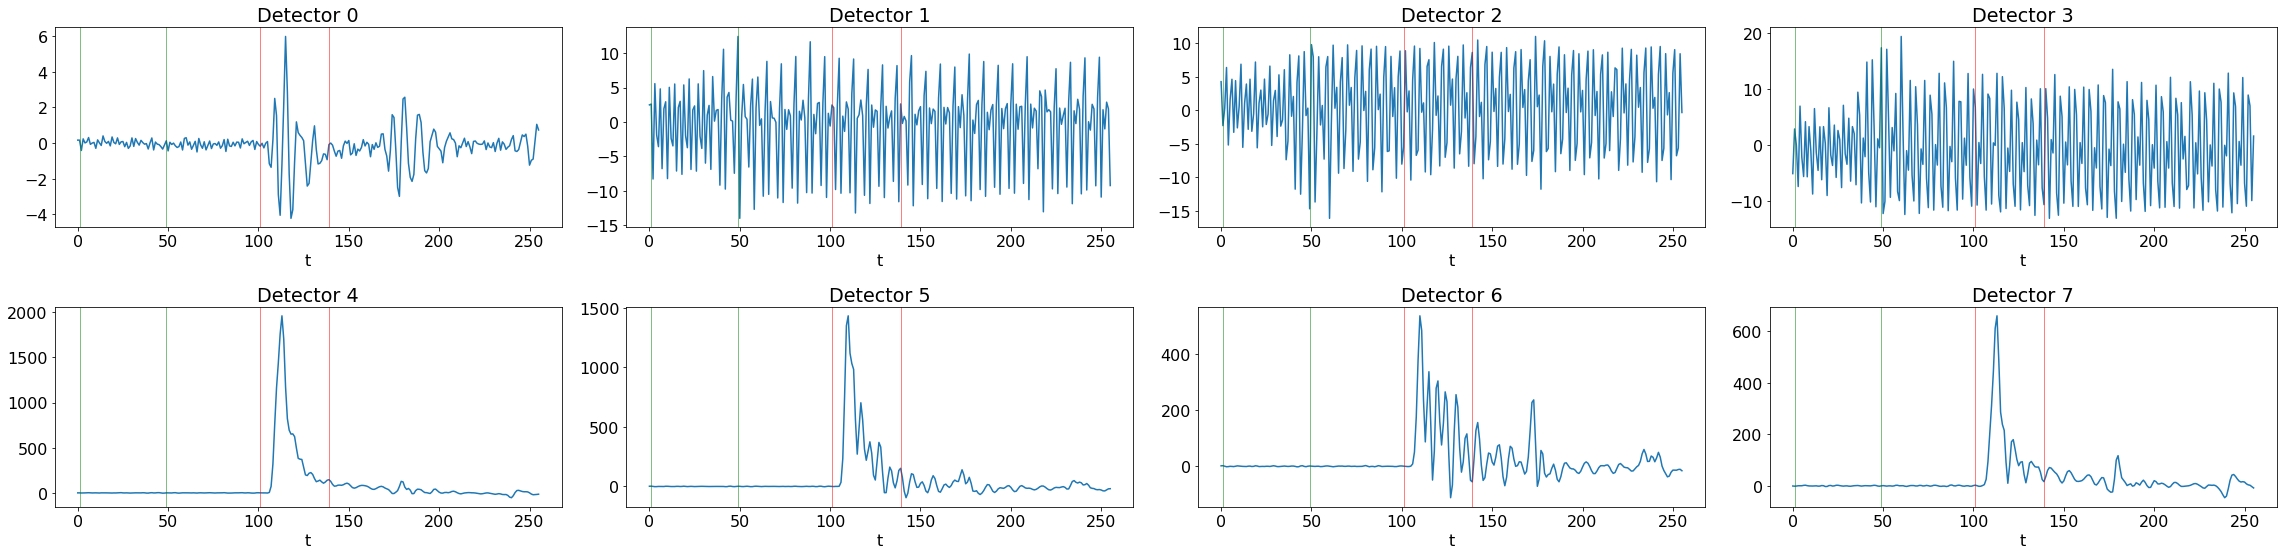

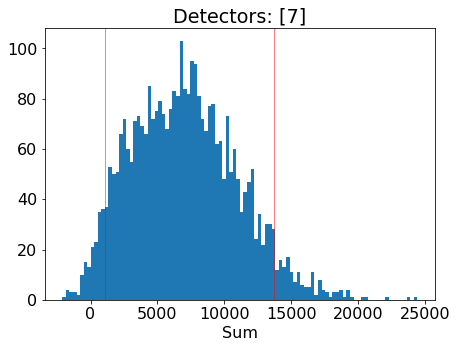

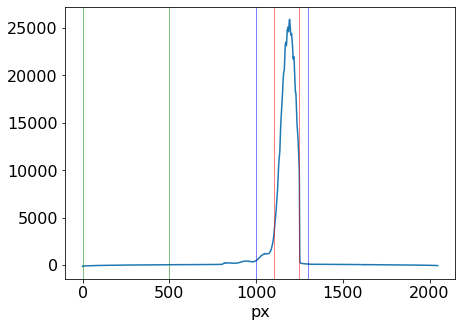

In [94]:
fim0 = fim()
fim0.load_run(fim0_raw)
fim0.set_msk([100,140])
fim0.set_detector_msk([7])
fim0.plot_waveforms()
fim0.set_shot_msk(percentile = 95)
fim0.hist()

andor_t = andor()
andor_t.load_run(andor_raw,fit=False)
andor_t.set_msk([1100,1250])
andor_t.set_fit_msk([1000,1300])
andor_t.plot_waveform()

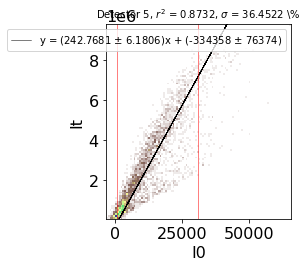

In [95]:
fim0_detectors = np.array([5])
fim0.set_detector_msk(fim0_detectors)
fim0.set_shot_msk(percentile = 95)
fim0.hist2d_all(andor_t.I_sum,msked = True)

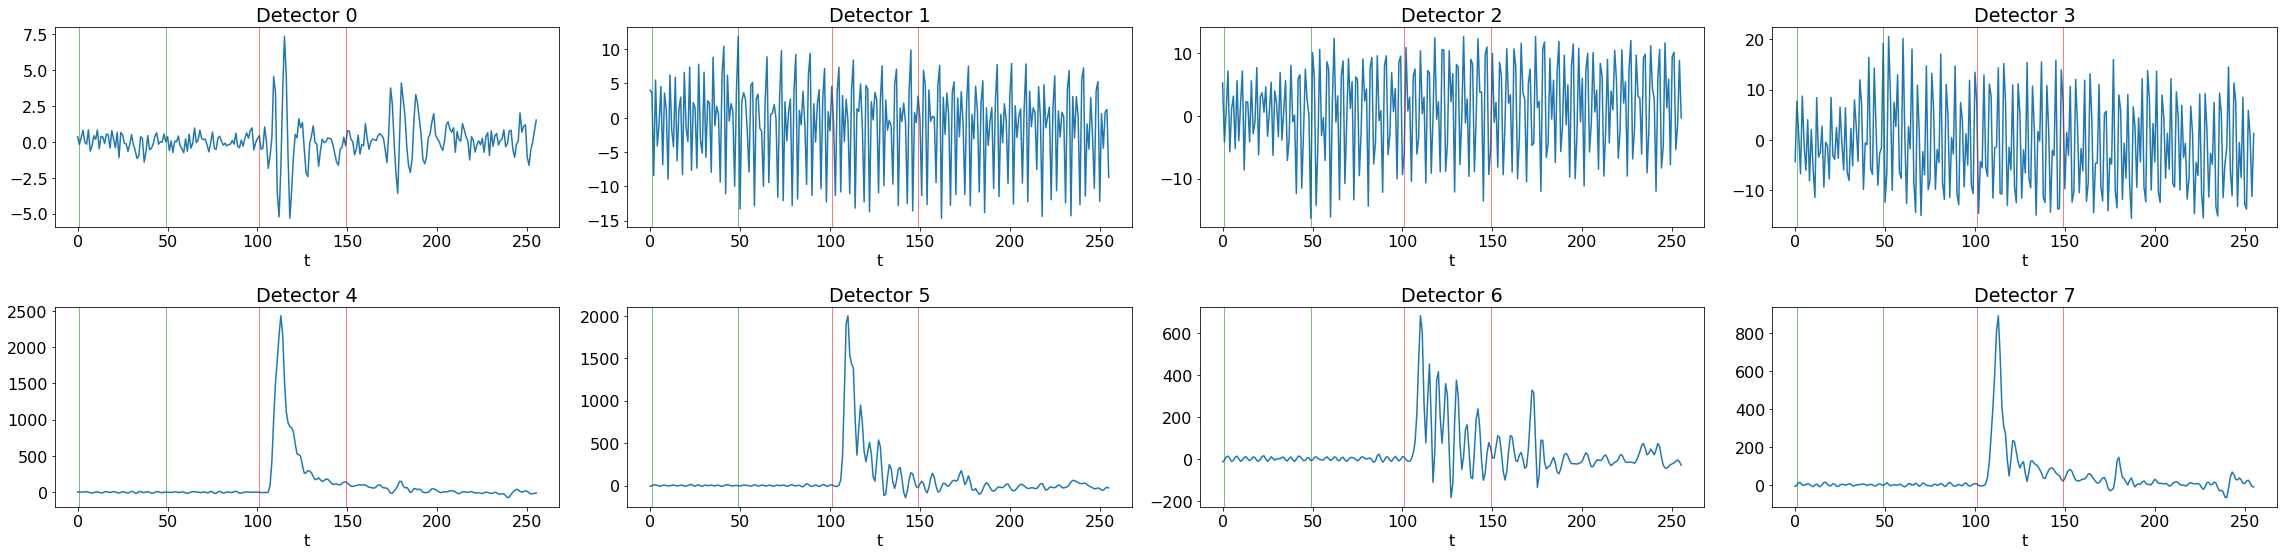

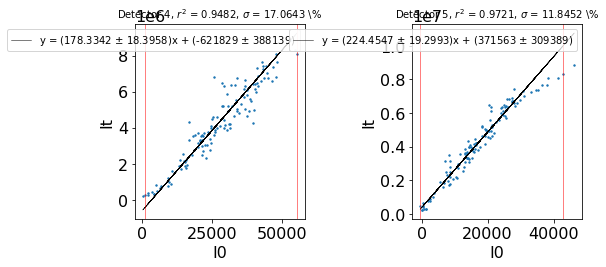

In [96]:
encoder_roi = [3840,3842]
encoder_msk = (mono_encoder>encoder_roi[0])&(mono_encoder<encoder_roi[1])
fim0_msked = fim()
fim0_msked.load_run(fim0_raw[encoder_msk])
fim0_msked.set_msk([100,150])
fim0_msked.set_detector_msk([4,5])
fim0_msked.plot_waveforms()
fim0_msked.set_shot_msk(percentile = 99.5)
fim0_msked.hist2d_all(andor_t.I_sum[encoder_msk],msked = True, bins = 70, scatter = True)

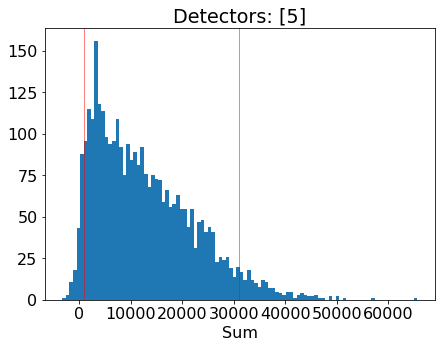

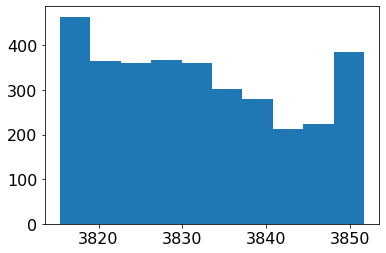

In [97]:
fim0.hist()
plt.figure()
plt.hist(mono_encoder)
encoder_bins = np.linspace(np.min(mono_encoder),np.max(mono_encoder),50)

2986 10 True
bootstrap bin


/cds/home/d/dgarratt/Code2020/chemRIXS/chemRIXSAnalysis.py:134: RuntimeWarning: Mean of empty slice
  binned_ratio = np.nanmean(binned_data/binned_norm, axis = 0)
/cds/sw/ds/ana/conda2/inst/envs/ps-4.4.3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<ErrorbarContainer object of 3 artists>

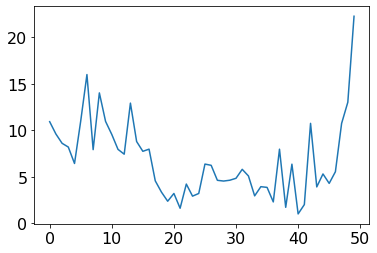

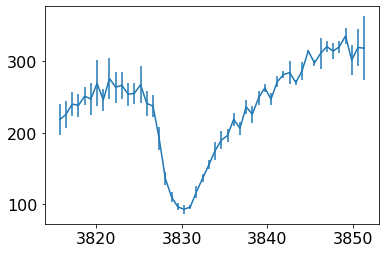

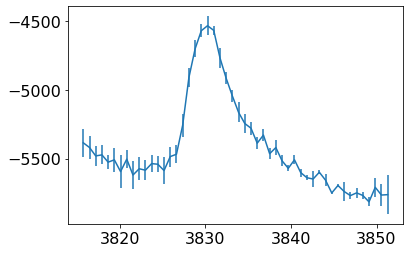

In [98]:
I0_bins = np.linspace(np.min(fim0.I_sum[msk_tmp]),np.max(fim0.I_sum[msk_tmp]),51)
encoder_bins = np.linspace(np.min(mono_encoder),np.max(mono_encoder),51)

msk_tmp = fim0.shot_msk
spec = mono_spectrum(mono_encoder,fim0.I_sum, andor_t.I_sum,msk_tmp)
spec.set_pitch_bins(encoder_bins)
I0_bins = np.linspace(np.min(fim0.I_sum[msk_tmp]),np.max(fim0.I_sum[msk_tmp]),50)
spec.nrepeat = 10
spec.calc_spectrum_mean_binned(I0_bins,bootstrap = True,nrepeat = 10,replace = True,count_threshold = 3)
count_msk = (spec.I0_binned>5)
tst = spec.I0_binned.copy()
tst[count_msk] = np.nan

plt.figure()
plt.plot(spec.transmission_binned_err)
plt.figure()
plt.errorbar(spec.pitch_bin_centers,spec.transmission_binned,spec.transmission_binned_err*2)
plt.figure()
plt.errorbar(spec.pitch_bin_centers,spec.OD_binned,spec.OD_binned_err*2)


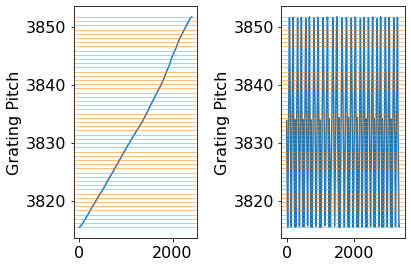

<Figure size 504x360 with 0 Axes>

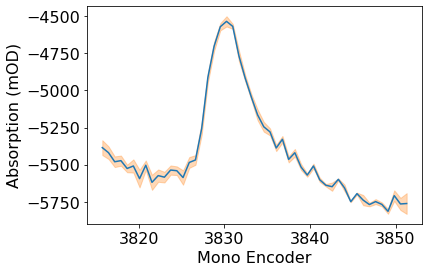

<Figure size 504x360 with 0 Axes>

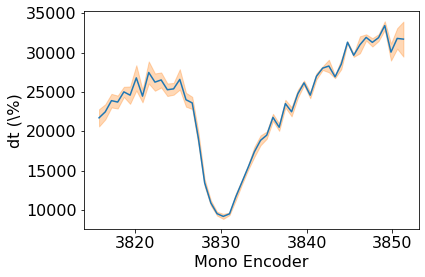

In [100]:
spec.plot_bins()
spec.plot_OD()
spec.plot_dt()

In [51]:
I0_bins = np.linspace(np.min(fim0.I_sum[msk_tmp]),np.max(fim0.I_sum[msk_tmp]),20)
encoder_bins = np.linspace(np.min(mono_encoder),np.max(mono_encoder),20)

msk_tmp = fim0.shot_msk
spec = mono_spectrum(mono_encoder,fim0.I_sum, andor_t.I_sum,msk_tmp)
spec.set_pitch_bins(encoder_bins)
spec.calc_spectrum_mean()
spec_nonorm = mono_spectrum(mono_encoder,np.ones(len(andor_t.I_sum)), andor_t.I_sum,msk_tmp)
spec_nonorm.set_pitch_bins(encoder_bins)
spec_nonorm.calc_spectrum_mean()


bootstrap bin
(19, 19, 1)


/cds/home/d/dgarratt/Code2020/chemRIXS/chemRIXSAnalysis.py:134: RuntimeWarning: Mean of empty slice
  binned_ratio = np.nanmean(binned_data/binned_norm, axis = 0)
/cds/sw/ds/ana/conda2/inst/envs/ps-4.4.3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<ErrorbarContainer object of 3 artists>

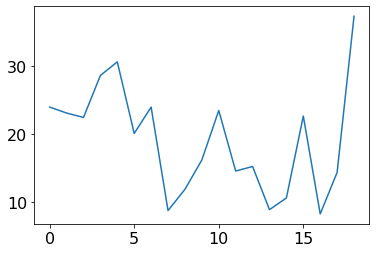

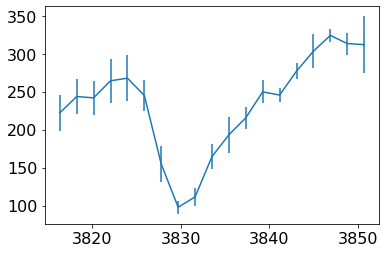

In [42]:
I0_bins = np.linspace(np.min(fim0.I_sum[msk_tmp]),np.max(fim0.I_sum[msk_tmp]),20)
encoder_bins = np.linspace(np.min(mono_encoder),np.max(mono_encoder),20)
bm, bs, bc = bin_norm_data_2d_bootstrap(spec.It, spec.I0, spec.I0, mono_encoder,I0_bins,encoder_bins,nsample = 100,replace = False)
#bm, bc = bin_data_2d(spec.It, spec.I0, spec.I0, mono_encoder,I0_bins,encoder_bins,nsample = 100,replace = False)

err = np.nanmean(bs,axis = 0).flatten()
plt.plot(err)
plt.figure()
print(bs.shape)
plt.errorbar(centers(encoder_bins),np.nanmean(bm,axis = 0).flatten(),err)

(19, 19, 1)


/cds/sw/ds/ana/conda2/inst/envs/ps-4.4.3/lib/python3.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: Mean of empty slice
/cds/sw/ds/ana/conda2/inst/envs/ps-4.4.3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<ErrorbarContainer object of 3 artists>

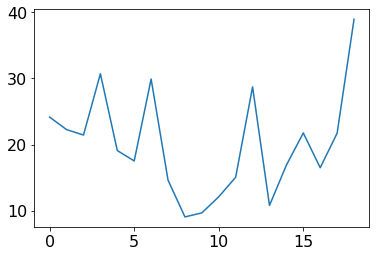

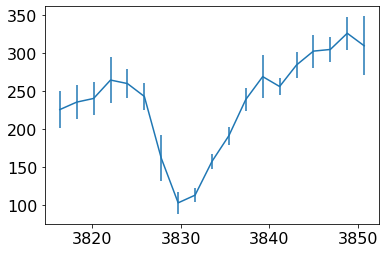

In [13]:
#plt.figure()
#plt.plot(spec.pitch_bin_centers,spec.transmission_binned.flatten())

def bin_norm_data_2d_bootstrap(data,norm, x_1, x_2,  edges_1, edges_2, count_threshold = 1,  ts=None, nsample = None, nrepeat=10,replace = True):
    # bins both data and norm on x_1 and x_2, applies a bin count threshold and calculates the ratio
    centers_1, centers_2 = [centers(edges_1),centers(edges_2)]
    if ts is None:
        dim_3 = 1
    else:
        dim_3 = len(ts)
        
    binned_data = np.zeros((nrepeat,len(centers_1),len(centers_2),dim_3))
    binned_norm = np.zeros((nrepeat,len(centers_1),len(centers_2),dim_3))
    bin_counts =np.zeros((nrepeat,len(centers_1),len(centers_2)))
    
    if nsample is None:
        nsample = len(data)
    
    for i in range(nrepeat):
        
        shots = np.random.choice(np.arange(len(data)), size = nsample, replace = replace)
        for i1,b1 in enumerate(edges_1[0:-1]):

            msk_1 = (x_1[shots]>edges_1[i1])&(x_1[shots]<=edges_1[i1+1])
            for i2, b2 in enumerate(edges_2[0:-1]):
                msk_2 = (x_2[shots]>edges_2[i2])&(x_2[shots]<=edges_2[i2+1])
                msk = msk_1&msk_2

                binned_data[i,i1,i2,:] = np.sum(data[shots][msk])
                binned_norm[i,i1,i2,:] = np.sum(norm[shots][msk])
                bin_counts[i,i1,i2]+= data[shots][msk].shape[0] 
    
    binned_data[bin_counts<count_threshold] = np.nan
    binned_norm[bin_counts<count_threshold] = np.nan
    binned_ratio = np.nanmean(binned_data/binned_norm, axis = 0)
    binned_std = np.nanstd(binned_data/binned_norm, axis = 0)
    
    return binned_ratio, binned_std, bin_counts

I0_bins = np.linspace(np.min(fim0.I_sum[msk_tmp]),np.max(fim0.I_sum[msk_tmp]),20)
encoder_bins = np.linspace(np.min(mono_encoder),np.max(mono_encoder),20)
bm, bs, bc = bin_norm_data_2d_bootstrap(spec.It, spec.I0, spec.I0, mono_encoder,I0_bins,encoder_bins,nsample = 100,replace = False)
#bm, bc = bin_data_2d(spec.It, spec.I0, spec.I0, mono_encoder,I0_bins,encoder_bins,nsample = 100,replace = False)

err = np.nanmean(bs,axis = 0).flatten()
plt.plot(err)
plt.figure()
print(bs.shape)
plt.errorbar(centers(encoder_bins),np.nanmean(bm,axis = 0).flatten(),err)

In [87]:
shots = np.random.choice(np.arange(len(spec.It)), size = 100, replace = False)
print(shots)
spec.It[shots]

[3062 2035 2945 1664  677 2108 1455 2828 1716 1892  398 2062  971  401
  688 2040  557  207  334 3074  562  635 1310 1570 2143 1833 1773 2299
 1820 1794 1872 2829 3039 1430  337  894 3010 1441 3228  456 3165  306
 1395 1205 3098 2567  833 1597 1679  349 1612 2083 2400 3286 2427 2140
 1387 1174 1689  171 2939 2930  807 1808 1248 2473 1480  837 2151 1898
  740   57 1865  816 2560  818  359 1317 2303  287   68 2652  425 1053
 2347  259 1653 2531 2947   21 2373 2954 1762 1796 3103  263  926 1776
 1177  607]


array([7868743.32464935, 6944227.13026063, 1006138.46893786,
        667354.29058117, 7253349.53507029,  402380.36272543,
       1809233.28857724, 3734773.94188359, 3521706.16633273,
        791666.41082165, 2447789.07615227, 1111287.36272548,
       2809469.47294582, 4195175.80961934, 4690235.82364713,
       3509722.36472951, 4928099.33266546, 2940172.15831662,
        212569.35070141,  607851.52705408, 6051123.69939899,
       1297133.77555106, 4347973.26052122,  790473.55110222,
       7577949.07014058,  492909.93386772, 1041179.34468943,
       1507195.61923847, 4825506.95791581,  438578.92384768,
       1122708.83767533,  883560.4288577 ,  810211.10821641,
       2540756.79759517, 1350617.10420846, 2339330.23446888,
       3091158.04408822, 1537211.19839678,  587733.97795589,
       1283229.50701409, 6806964.51302637, 6644031.46292607,
       1571957.09418832, 2359604.88176355,  728318.48496999,
        972218.91583162, 3340302.53106223, 3308801.55911823,
       1627775.78757522,

(10, 19, 19, 1)
(10,)
0.0


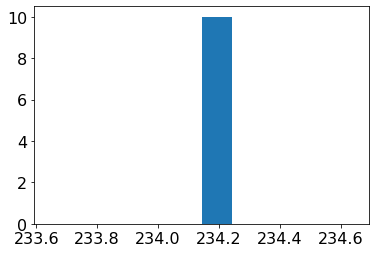

In [78]:
ratio = bd/bn
print(ratio.shape)
tst = np.nanmean(np.nanmean(np.nanmean(ratio,axis = 1),axis = 1),axis = 1)
print(tst)
plt.hist(tst)
print(np.std(tst))

In [ ]:
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.errorbar(spec.pitch_bin_centers,spec.OD,spec.OD_err,capsize = 2)
plt.xlabel('Encoder Value')
plt.ylabel('-log_10(Andor / FIM 0)')
plt.title('Run {:}, Normalised to FIM 0 Detectors 4, 5'.format(run))
plt.subplot(1,2,2)
plt.errorbar(spec_nonorm.pitch_bin_centers,spec_nonorm.OD,spec_nonorm.OD_err,capsize = 2)
plt.xlabel('Encoder Value')
plt.ylabel('-log_10(Andor / FIM 0)')
plt.title('Run {:}, No normalisation'.format(run))
plt.tight_layout()
print(np.sum(spec.bin_count)/(10*60))
print(np.average(spec.OD_err))
print(np.average(spec_nonorm.OD_err))

In [ ]:
runs = [515]
preproc_folder = '/reg/data/ana16/rix/rixx43518/scratch/preproc/v1'
preproc_prefix = 'run'
preproc_suffix = '_v1.h5'

run = runs[0]
preproc_sp = os.path.join(preproc_folder,'{:}{:}{:}'.format(preproc_prefix,run,preproc_suffix))
raw = h5py.File(preproc_sp,'r')
#print(raw.keys())
#xgmd = np.array(raw['xgmd_energy'])
#gmd = np.array(raw['gmd_energy'])

fim0_raw = np.array(raw['fim0_raw'])
fim2_raw = np.array(raw['fim2_raw'])
fim1_raw = np.array(raw['fim1_raw'])
mono_encoder = np.array(raw['mono_encoder'])
#andor_raw = np.array(raw['andor'])
pitch_raw = np.array(raw['epics_MONO_GRATING_PITCH'])
horz_raw = np.array(raw['epics_MR3K4_pitch'])
evrs = np.array(raw['evrs'])
pitch_raw = pitch_raw - 1.607501e5

fim2 = fim()
#fim2.threshold = 0
fim2.load_run(fim2_raw)
fim2.set_msk([55,85])
fim2.set_shot_msk(percentile = 90)
fim2_detectors = np.array([7])
fim2.set_detector_msk(fim2_detectors)
fim2.plot_waveforms(msked = True,figsize = (7,5))

In [ ]:
fim0 = fim()
fim0.load_run(fim0_raw)
fim0.set_msk([100,140])
fim0.plot_waveforms()
fim0.set_shot_msk(percentile = 95)
fim0_detectors = np.array([4,5])
fim0.set_detector_msk(fim0_detectors)
fim0.set_shot_msk(percentile = 90)
fim0.hist()
fim0.hist2d_all(fim2.I_sum,msked=True)

In [ ]:
fim1 = fim()
fim1.load_run(fim1_raw)
fim1.set_msk([100,150])
fim1.plot_waveforms()
fim1.set_shot_msk(percentile = 95)
fim1_detectors = np.array([4,5,6,7])
fim1.set_detector_msk(fim1_detectors)
fim1.average_I()
fim1.set_shot_msk(percentile = 99)
fim1.hist()

fim1.hist2d(fim2.I_sum)
plt.axvline(7000)

In [ ]:
msk_tmp = fim1.shot_msk&(fim1.I_sum>10000)

encoder_bins = np.linspace(np.min(mono_encoder),np.max(mono_encoder),50)
encoder_bin_centers = centers(encoder_bins)
spec = mono_spectrum(mono_encoder,fim1.I_sum, fim2.I_sum,msk_tmp)
spec.set_pitch_bins(encoder_bins)
spec.calc_spectrum_mean()

In [ ]:
I0_bins = np.linspace(np.min(fim1.I_sum[msk_tmp]),np.max(fim1.I_sum[msk_tmp]),150)
plt.hist(fim1.I_sum[msk_tmp],bins = I0_bins)
spec.calc_spectrum_mean_binned(I0_bins)
print(spec.I0_binned.shape)
print(spec.I0_binned[spec.I0_binned>1].shape)
tst = np.nanmean(spec.It_binned/spec.I0_binned,axis = 0)
plt.figure()
plt.plot(spec.pitch_bin_centers,tst)

In [ ]:
spec_nonorm = mono_spectrum(mono_encoder,1*np.ones(len(fim2.I_sum)), fim2.I_sum+1e6,msk_tmp)
spec_nonorm.set_pitch_bins(encoder_bins)
spec_nonorm.calc_spectrum_mean()

In [ ]:
spec.plot_bins()
spec_nonorm.plot_yield()
spec.plot_yield()

In [ ]:
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.errorbar(spec.pitch_bin_centers,spec.transmission,spec.transmission_err,capsize = 2)
plt.xlabel('Encoder Value')
plt.ylabel('I / FIM 1')
plt.title('Run {:}, Normalised to FIM 0 Detectors 4, 5, 6, 7'.format(run))
plt.subplot(1,2,2)
plt.errorbar(spec_nonorm.pitch_bin_centers,spec_nonorm.transmission,spec_nonorm.transmission_err,capsize = 2)
plt.xlabel('Encoder Value')
plt.ylabel('I / FIM 1')
plt.title('Run {:}, No normalisation'.format(run))
plt.tight_layout()
print(spec.bin_count)
print(np.average(spec.transmission_err/spec.transmission))
print(np.average(spec_nonorm.transmission_err/spec_nonorm.transmission))

In [ ]:
encoder_bins = np.linspace(np.min(mono_encoder),np.max(mono_encoder),50)
encoder_bin_centers = centers(encoder_bins)
print(fim0.I_sum.shape)
print(andor_t.I_sum.shape)
msk_tmp = fim0.shot_msk
print(msk_tmp.shape)
t_binned, t_binned_std, t_bc = bin_data_1d_bootstrap((andor_t.I_sum/fim0.I_sum)[msk_tmp], mono_encoder[msk_tmp],encoder_bins)
print(t_binned.shape)
pitch_bin_means, bc = bin_data_1d(mono_encoder, mono_encoder,encoder_bins)
pitch_bin_means = pitch_bin_means.flatten()

bin_msk = t_bc>0.5
spectrum = t_binned.flatten()
print(spectrum.shape)
s_err = t_binned_std.flatten()
dt = (spectrum -1)*100
dt_err = s_err *100
plt.figure()

plt.errorbar(encoder_bin_centers[bin_msk],dt[bin_msk],dt_err,label = 'FIM 0 mean')
plt.ylabel('delta T (\%)')
plt.figure()
plt.plot(encoder_bin_centers[bin_msk],spectrum[bin_msk],label = 'FIM 0 mean')

In [ ]:
encoder_bins = np.linspace(np.min(mono_encoder),np.max(mono_encoder),50)
encoder_bin_centers = centers(encoder_bins)
plt.hist(mono_encoder,encoder_bins)
plt.figure()
msk_tmp = fim2.shot_msk
t_binned, t_binned_std, t_bc = bin_data_1d_bootstrap(fim2.I_sum, mono_encoder,encoder_bins)
print(t_binned.shape)
pitch_bin_means, bc = bin_data_1d(mono_encoder, mono_encoder,encoder_bins)
pitch_bin_means = pitch_bin_means.flatten()

bin_msk = t_bc>0.5
spectrum = t_binned.flatten()
print(spectrum.shape)
s_err = t_binned_std.flatten()
dt = (spectrum -1)*100
dt_err = s_err *100
plt.figure()

plt.errorbar(encoder_bin_centers[bin_msk],dt[bin_msk],dt_err,label = 'FIM 0 mean')
plt.ylabel('delta T (\%)')
plt.figure()
plt.plot(encoder_bin_centers[bin_msk],spectrum[bin_msk],label = 'FIM 0 mean')


In [ ]:
fim0 = fim()
fim0.set_msk([100,140])
fim0.load_run(fim0_raw)
fim1 = fim()
fim1.set_msk([100,140])
fim1.load_run(fim1_raw)

fim0.plot_waveforms()
fim1.plot_waveforms()

In [ ]:
fim0 = fim()
fim0.set_msk([100,140])
fim0.load_run(fim0_raw)
fim1 = fim()
fim1.set_msk([100,140])
fim1.load_run(fim1_raw)


#andor_t = andor()
andor_t.load_run(andor_raw)
andor_t.set_msk([1100,1250])
andor_t.set_fit_msk([1000,1300])

fim1_detectors = np.array([4,5,6,7])
fim0_detectors = np.array([5])
fim0.set_detector_msk(fim0_detectors)
fim1.set_detector_msk(fim1_detectors)

fim0.set_shot_msk(percentile = 95)
fim1.set_shot_msk(percentile = 95)

fim1.hist2d_all(andor_t.I_sum,msked = True)

#fim0.set_shot_msk(I_roi = fim0_roi)
#fim1.calibrate(andor_t.I_sum)
#fim1.hist2d(andor_t.I_sum)
fim1.calibrate(andor_t.I_sum)
fim1.hist2d(andor_t.I_sum)
fim0.calibrate(andor_t.I_sum)
fim0.hist2d(andor_t.I_sum)

In [ ]:
tst = mono_spectrum(grating_pos=pitch_raw,I0=fim0.I_sum,It=andor_t.I_sum,msk=fim0.shot_msk)
tst.set_pitch_bins(np.arange(0.03,0.1,0.007))

tst.plot_bins()
tst.calc_spectrum_mean()
tst.plot_dt()
tst.plot_OD()

In [ ]:
runs = [359]
preproc_folder = '/reg/data/ana16/rix/rixx43518/scratch/preproc/v0'
preproc_prefix = 'run'
preproc_suffix = '_v0.h5'

run = runs[0]
preproc_sp = os.path.join(preproc_folder,'{:}{:}{:}'.format(preproc_prefix,run,preproc_suffix))
raw = h5py.File(preproc_sp,'r')
xgmd = np.array(raw['xgmd_energy'])
gmd = np.array(raw['gmd_energy'])
fim0_raw = np.array(raw['fim0_raw'])
fim1_raw = np.array(raw['fim1_raw'])
andor_raw = np.array(raw['andor'])
pitch_raw = np.array(raw['epics_MONO_GRATING_PITCH'])
horz_raw = np.array(raw['epics_MR3K4_pitch'])
pitch_raw = pitch_raw - 1.607501e5

In [ ]:
#fim0.set_shot_msk(I_roi = fim0_roi)
#fim1.calibrate(andor_t.I_sum)
#fim1.hist2d(andor_t.I_sum)
fim1.calibrate(andor_t.I_sum)
fim1.hist2d(andor_t.I_sum)
fim0.calibrate(andor_t.I_sum)
fim0.hist2d(andor_t.I_sum)

In [ ]:
#fim0.set_shot_msk(I_roi = fim0_roi)
#fim1.calibrate(andor_t.I_sum)
#fim1.hist2d(andor_t.I_sum)
fim1.calibrate(andor_t.I_sum)
fim1.hist2d(andor_t.I_sum)
fim0.calibrate(andor_t.I_sum)
fim0.hist2d(andor_t.I_sum)

In [ ]:
resolution = 410/2000
e_range = 20
t = 10
dt = t/e_range
nbins = 2.5/dt
print(dt,nbins)

In [ ]:
plt.plot(pitch_raw)
print(np.min(pitch_raw),np.max(pitch_raw))
msk_tmp = fim0.shot_msk
pitch_bins = np.arange(0.03,0.1,0.007)
pitch_bin_centers = centers(pitch_bins)
transmission = andor_t.I_sum[msk_tmp]/fim0.I_sum[msk_tmp]
t_binned, t_binned_std, t_bc = bin_data_1d_bootstrap(transmission, pitch_raw[msk_tmp],pitch_bins)
pitch_bin_means, bc = bin_data_1d(pitch_raw, pitch_raw,pitch_bins)
pitch_bin_means = pitch_bin_means.flatten()
bin_msk = t_bc>0.5
spectrum = t_binned.flatten()
s_err = t_binned_std.flatten()
dt = (spectrum -1)*100
dt_err = s_err *100
plt.figure()
plt.errorbar(pitch_bin_centers[bin_msk],dt[bin_msk],dt_err, label = 'FIM 1 mean')
plt.ylabel('delta T (\%)')


#msk_tmp = (fim0.I_sum>0.5e6)&(fim0.I_sum<2.5e6)
msk_tmp = fim1.shot_msk

pitch_bins = np.arange(0.03,0.1,0.007)
pitch_bin_centers = centers(pitch_bins)
t_binned, t_binned_var, t_binned_err, t_bc = regress_data_1d(fim1.I_sum[msk_tmp],andor_t.I_sum[msk_tmp], pitch_raw[msk_tmp],pitch_bins, fix_intercept = True)
pitch_bin_means, bc = bin_data_1d(pitch_raw, pitch_raw,pitch_bins)
pitch_bin_means = pitch_bin_means[:,0]/bc

bin_msk = t_bc>0.5
spectrum = t_binned.flatten()
dt = (spectrum -1)*100
absorption = -np.log10(spectrum)
print(t_bc.shape)
plt.errorbar(pitch_bin_means[bin_msk],dt[bin_msk],t_binned_var[bin_msk]*100,label = 'FIM 1 linear regression')
plt.legend()



In [ ]:
plt.plot(pitch_raw)
print(np.min(pitch_raw),np.max(pitch_raw))
msk_tmp = fim1.shot_msk
pitch_bins = np.arange(0.03,0.1,0.007)
pitch_bin_centers = centers(pitch_bins)
transmission = andor_t.I_sum[msk_tmp]/fim0.I_sum[msk_tmp]
t_binned, t_binned_std, t_bc = bin_data_1d_bootstrap(transmission, pitch_raw[msk_tmp],pitch_bins)
pitch_bin_means, bc = bin_data_1d(pitch_raw, pitch_raw,pitch_bins)
pitch_bin_means = pitch_bin_means.flatten()

bin_msk = t_bc>0.5
spectrum = t_binned.flatten()
s_err = t_binned_std.flatten()
dt = (spectrum -1)*100
dt_err = s_err *100
plt.figure()

plt.errorbar(pitch_bin_centers[bin_msk],dt[bin_msk],dt_err,label = 'FIM 0 mean')
plt.ylabel('delta T (\%)')


#msk_tmp = (fim0.I_sum>0.5e6)&(fim0.I_sum<2.5e6)
msk_tmp = fim1.shot_msk

pitch_bins = np.arange(0.03,0.1,0.007)
pitch_bin_centers = centers(pitch_bins)
t_binned, t_binned_var, t_binned_err, t_bc = regress_data_1d(fim0.I_sum[msk_tmp],andor_t.I_sum[msk_tmp], pitch_raw[msk_tmp],pitch_bins, fix_intercept = True)
pitch_bin_means, bc = bin_data_1d(pitch_raw, pitch_raw,pitch_bins)
pitch_bin_means = pitch_bin_means[:,0]/bc

bin_msk = t_bc>0.5
spectrum = t_binned.flatten()
dt = (spectrum -1)*100
absorption = -np.log10(spectrum)
print(t_bc.shape)
plt.errorbar(pitch_bin_centers[bin_msk],dt[bin_msk],t_binned_var[bin_msk]*100,label = 'FIM 0 linear regression')
plt.legend()

In [ ]:
msk_tmp = fim1.shot_msk
pitch_bins = np.arange(0.03,0.1,0.007)
pitch_bin_centers = centers(pitch_bins)
transmission = andor_t.I_sum[msk_tmp]/fim0.I_sum[msk_tmp]
n_b = 500
It_bins = np.linspace(np.min(andor_t.I_sum[msk_tmp]),np.max(andor_t.I_sum[msk_tmp]),n_b)
I0_bins = np.linspace(np.min(fim0.I_sum[msk_tmp]),np.max(fim0.I_sum[msk_tmp]),n_b)

It_bin = bin_data_1d(andor_t.I_sum[msk_tmp],

In [ ]:
plt.plot(pitch_raw)
print(np.min(pitch_raw),np.max(pitch_raw))
msk_tmp = fim1.shot_msk
pitch_bins = np.arange(0.03,0.1,0.007)
pitch_bin_centers = centers(pitch_bins)
transmission = andor_t.I_sum[msk_tmp]/fim1.I_sum[msk_tmp]
t_binned, t_bc = bin_data_1d(transmission, pitch_raw[msk_tmp],pitch_bins)
pitch_bin_means, bc = bin_data_1d(pitch_raw, pitch_raw,pitch_bins)
pitch_bin_means = pitch_bin_means[:,0]/bc

bin_msk = t_bc>0.5
spectrum = t_binned.flatten()/t_bc
dt = (spectrum -1)*100
print(t_bc.shape)
plt.figure()
plt.plot(pitch_bin_centers[bin_msk],spectrum[bin_msk],'x-')
plt.figure()
plt.plot(pitch_bin_means[bin_msk],dt[bin_msk],'x-')


In [ ]:
plt.plot(pitch_raw)
print(np.min(pitch_raw),np.max(pitch_raw))
msk_tmp = fim1.shot_msk
pitch_bins = np.arange(0.03,0.1,0.007)
pitch_bin_centers = centers(pitch_bins)
transmission = andor_t.I_sum[msk_tmp]/fim1.I_sum[msk_tmp]
t_binned, t_bc = bin_data_1d(andor_t.I_sum[msk_tmp]/, pitch_raw[msk_tmp],pitch_bins)
pitch_bin_means, bc = bin_data_1d(pitch_raw, pitch_raw,pitch_bins)
pitch_bin_means = pitch_bin_means[:,0]/bc

bin_msk = t_bc>0.5
spectrum = t_binned.flatten()/t_bc
print(t_bc.shape)
plt.figure()
plt.plot(pitch_bin_centers[bin_msk],spectrum[bin_msk],'x-')
plt.figure()
plt.plot(pitch_bin_means[bin_msk],spectrum[bin_msk],'x-')
plt.figure()
plt.plot((t_bc))

plt.figure()
plt.scatter(pitch_bin_means[bin_msk],spectrum[bin_msk])

In [ ]:
#msk_tmp = (fim0.I_sum>0.5e6)&(fim0.I_sum<2.5e6)
msk_tmp = fim1.shot_msk

pitch_bins = np.arange(0.03,0.1,0.05)
pitch_bin_centers = centers(pitch_bins)
t_binned, t_binned_var, t_binned_err, t_bc = regress_data_1d(fim1.I_sum[msk_tmp],andor_t.I_sum[msk_tmp], pitch_raw[msk_tmp],pitch_bins, fix_intercept = True)
pitch_bin_means, bc = bin_data_1d(pitch_raw, pitch_raw,pitch_bins)
pitch_bin_means = pitch_bin_means[:,0]/bc

bin_msk = t_bc>0.5
spectrum = t_binned.flatten()
dt = (spectrum -1)*100
absorption = -np.log10(spectrum)
print(t_bc.shape)
plt.figure()
plt.errorbar(pitch_bin_centers[bin_msk],spectrum[bin_msk],t_binned_var[bin_msk]*2)
plt.figure()
plt.errorbar(pitch_bin_centers[bin_msk],dt[bin_msk],t_binned_var[bin_msk]*200)




In [ ]:
andor_tst = andor()
andor_tst.set_msk([1100,1250])
andor_tst.set_fit_msk([1000,1300])
andor_tst.load_run(andor_raw[0:1000,:],fit = True)
print(andor_tst.fit_msk)
andor_tst.plot_waveform()
plt.xlim(900,1500)
andor_tst.hist()
andor_tst.hist_coeffs()

In [ ]:
tst = fim()
tst.set_msk([100,140])
tst.load_run(fim0_raw)
print(tst.detector_msk)
print(tst.I_sums[:,:].shape)
print(tst.I_sums[:,tst.detector_msk].shape)
tst.plot_waveforms()
tst.hist()
tst.set_detector_msk([4])
tst.plot_waveform()
tst.hist_all(msked = True)
tst.hist()

In [ ]:
plt.figure()
plt.plot(pitch_raw)
precision=1
plt.plot(myround(pitch_raw,precision))
#def get_stage_bins(values, precision):
plt.figure()
plt.plot(np.unique(pitch_raw))
plt.plot(np.unique(myround(pitch_raw,precision)))

def 

In [ ]:
print(andor_raw.shape)
px = np.arange(2048)
bg_msk = (px>0)&(px<500)
print(andor_raw[:,bg_msk].shape)
bgs = np.average(andor_raw[:,bg_msk],axis = 1)
plt.plot(np.average(andor_raw-bgs[:,np.newaxis],axis = 0))
plt.xlim(1000,1500)
plt.plot((andor_raw-bgs[:,np.newaxis])[10])
plt.axvline(1050)
plt.axvline(1300)
andor_raw_nbg = andor_raw-bgs[:,np.newaxis]
andor_sums = process_andor(andor_raw,bg_roi = [0,500], roi = [1050,1300])
andor_fits = fit_andor(andor_raw_nbg,roi = [1050,1300])
print(andor_sums.shape)
s = np.average(andor_raw-bgs[:,np.newaxis],axis = 0)
p0 = [np.max(s),px[np.argmax(s)],20,0]
plt.plot(px,gauss(px,*p0))

In [ ]:
print(andor_fits.shape)
andor_sums_fit = np.multiply(andor_fits[:,0], andor_fits[:,2])
plt.hist2d(andor_sums,andor_sums_fit,bins = 100)
plt.figure()

In [ ]:
ts = np.arange(256)
fim0_proc = np.apply_along_axis(process_I0_monitor,2,fim0_raw)
fim1_proc = np.apply_along_axis(process_I0_monitor,2,fim1_raw)
f = np.fft.fftfreq(len(ts))
fim0_ffts = np.apply_along_axis(np.fft.fft,2,fim0_proc)
fim0_ffts = np.apply_along_axis(np.abs,2,fim0_ffts)
fim1_ffts = np.apply_along_axis(np.fft.fft,2,fim1_proc)
fim1_ffts = np.apply_along_axis(np.abs,2,fim1_ffts)
fim0_sums = np.sum(fim0_proc[:,:,:],axis = 2)
fim1_sums = np.sum(fim1_proc[:,:,:],axis = 2)
fim0_avs = np.average(fim0_proc,axis = 0)
fim1_avs = np.average(fim1_proc,axis = 0)

In [ ]:
fim0_detectors = np.array([4,5])
#fim0_detectors = np.arange(8)
fim0_msk = np.zeros(8).astype('bool')
fim0_msk[fim0_detectors] = True

fim1_detectors = np.array([4,5,6,7])
#fim1_detectors = np.arange(8)
fim1_msk = np.zeros(8).astype('bool')
fim1_msk[fim1_detectors] = True
print(fim1_msk)

In [ ]:
fim_roi = [105,150]
#fim_roi = [0,256]
fim_msk = (ts>fim_roi[0])&(ts<fim_roi[1])
print(fim0_proc[:,:,fim_msk].shape)
plot_wav(ts,fim0_avs,vlines = fim_roi)
plot_wav(ts,fim1_avs,vlines = fim_roi)
fim0_sums = np.sum(fim0_proc[:,:,fim_msk],axis = 2)
fim1_sums = np.sum(fim1_proc[:,:,fim_msk],axis = 2)

In [ ]:
plt.hist(andor_sums,bins = 100)
plt.figure()
print(fim0_sums.shape)

In [ ]:
shot_msk = (andor_sums>0.75e6)&(andor_sums<2.75e6)&(fim0_sums[:,5]>10000)

fim0_detectors = np.array([4,5])
fim1_detectors = np.array([4,5,6,7])

fim0_detectors = np.array([5])
#fim0_detectors = np.arange(8)
fim0_msk = np.zeros(8).astype('bool')
fim0_msk[fim0_detectors] = True

#fim1_detectors = np.array([7])
#fim1_detectors = np.arange(8)
fim1_msk = np.zeros(8).astype('bool')
fim1_msk[fim1_detectors] = True


hist_wav(fim0_sums[:,fim0_msk],axis = 1)
hist2d_wav(fim0_sums[:,fim0_msk][shot_msk,:],andor_sums_fit[shot_msk],axis = 1)

hist_wav(fim1_sums[:,fim1_msk][shot_msk,:],axis = 1)
hist2d_wav(fim1_sums[:,fim1_msk][shot_msk,:],andor_sums_fit[shot_msk],axis = 1)



In [ ]:
transmission = fim0_sums[:,fim0_msk][:,0]/andor_sums
plt.hist(transmission[shot_msk],bins = 200)
print(np.std(transmission[shot_msk]/np.average(transmission[shot_msk])))

nsample = 1000
nrepeat = 500
coeff, var = bootstrap_fit(straight_line,andor_sums[shot_msk],fim0_sums[:,fim0_msk][:,0][shot_msk],[np.average(transmission[shot_msk]),0],nsample,nrepeat)
std_err = var/np.sqrt(nsample)
print(coeff,var, var[0]/coeff[0] *100, std_err/coeff[0] *100)


transmission = fim_averages/andor_sums
coeff, var = bootstrap_fit(straight_line,andor_sums[shot_msk],fim_averages[shot_msk],[np.average(transmission[shot_msk]),0],nsample,nrepeat)
std_err = var/np.sqrt(nsample)
print(coeff,var, var[0]/coeff[0]*100, std_err/coeff[0] *100 )
plt.figure()
plt.hist(transmission[shot_msk],bins = 200)
plt.axvline(coeff[0],color='r')
plt.axvline(np.average(transmission[shot_msk]),color='g')
plt.figure()


transmission = fim0_sums[:,4]/andor_sums
plt.hist(transmission[shot_msk],bins = 200)
print(np.std(transmission[shot_msk]/np.average(transmission[shot_msk])))

nsample = 1000
nrepeat = 500
coeff, var = bootstrap_fit(straight_line,andor_sums[shot_msk],fim0_sums[:,4][shot_msk],[np.average(transmission[shot_msk]),0],nsample,nrepeat)
std_err = var/np.sqrt(nsample)
print(coeff,var, var[0]/coeff[0]*100, std_err/coeff[0] *100)
plt.axvline(coeff[0],color='r')
plt.axvline(np.average(transmission[shot_msk]),color='g')
plt.figure()

In [ ]:
nsample = 100
nrepeat = 500

transmission = fim_averages/andor_sums
coeff, var = bootstrap_fit(straight_line,andor_sums[shot_msk],fim_averages[shot_msk],[np.average(transmission[shot_msk]),0],nsample,nrepeat)
std_err = var/np.sqrt(nsample)
print(coeff,var, var[0]/coeff[0]*100, std_err/coeff[0] *100 )
plt.figure()
plt.hist(transmission[shot_msk],bins = 200)
plt.axvline(coeff[0],color='r')
plt.axvline(np.average(transmission[shot_msk]),color='g')
plt.figure()
coeff_0, var_0 = bootstrap_fit(straight_line_zero,andor_sums[shot_msk],fim_averages[shot_msk],[np.average(transmission[shot_msk])],nsample,nrepeat)

plt.hist2d(andor_sums[shot_msk],fim_averages[shot_msk], bins = 100)

x_plot = np.linspace(0,np.max(andor_sums[shot_msk]),1000)
plt.plot(x_plot,straight_line_zero(x_plot,coeff_0[0]),'r')
plt.plot(x_plot,straight_line(x_plot,coeff[0],coeff[1]),'m')
plt.xlim(0,np.max(andor_sums[shot_msk]))
plt.ylim(0,np.max(fim_averages[shot_msk]))
plt.xlabel('$I_T$')
plt.ylabel('$I_0$')

plt.figure()
transmission = fim_averages/andor_sums
coeff, var = bootstrap_fit(straight_line,andor_sums_fit[shot_msk],fim_averages[shot_msk],[np.average(transmission[shot_msk]),0],nsample,nrepeat)
std_err = var/np.sqrt(nsample)
print('I/I0 = {:.4f}, std = {:.4f} , err = {:.4f} , intercept = {:.4f}'.format(coeff[0],var[0]/coeff[0],std_err[0]/coeff[0],coeff[1]/np.average(fim_averages)))

plt.figure(figsize = (10,10))
coeff_0, var_0 = bootstrap_fit(straight_line_zero,andor_sums_fit[shot_msk],fim_averages[shot_msk],[np.average(transmission[shot_msk])],nsample,nrepeat)
print('I/I0 = {:.4f}, std = {:.4f} , err = {:.4f} '.format(coeff_0[0],var_0[0]/coeff[0],std_err[0]/coeff_0[0]))

plt.hist2d(andor_sums_fit[shot_msk],fim_averages[shot_msk], bins = 200,cmap = cmap)
plt.colorbar()
x_plot = np.linspace(0,np.max(andor_sums_fit[shot_msk]),1000)
plt.plot(x_plot,straight_line(x_plot,coeff[0],coeff[1]),'k',lw = 1)
plt.plot(x_plot,straight_line(x_plot,coeff[0]+std_err[0]*4,coeff[1]+std_err[1]),'m',lw=1)
plt.plot(x_plot,straight_line(x_plot,coeff[0]-std_err[0]*4,coeff[1]-std_err[1]),'m',lw=1)
#plt.xlim(0,np.max(andor_sums[shot_msk]))
#plt.ylim(0,np.max(fim_averages[shot_msk]))
plt.xlabel('$I_T$')
plt.ylabel('$I_0$')


In [ ]:
print(len(andor_sums)/(120*60))

In [ ]:
fim0_detectors = np.array([5])
fim1_detectors = np.array([4,5,6,7])

#fim0_detectors = np.array([5])
#fim0_detectors = np.arange(8)
fim0_msk = np.zeros(8).astype('bool')
fim0_msk[fim0_detectors] = True

#fim1_detectors = np.array([7])
#fim1_detectors = np.arange(8)
fim1_msk = np.zeros(8).astype('bool')
fim1_msk[fim1_detectors] = True
print(fim1_msk)

total_fim_detectors = len(fim0_msk[fim0_msk==True])+len(fim1_msk[fim1_msk==True])
print(total_fim_detectors)
fim_averages = (np.sum(fim0_sums[:,fim0_msk],axis = 1)+np.sum(fim1_sums[:,fim1_msk],axis = 1))/total_fim_detectors
rho = st.pearsonr(fim_averages[shot_msk],andor_sums[shot_msk])[0]

coeffs = np.polyfit(fim_averages[shot_msk],andor_sums[shot_msk],1)
fit = np.poly1d(coeffs)(fim_averages)
print(fit)
residual = andor_sums-fit
sigma = np.std(residual[shot_msk])/np.average(andor_sums[shot_msk])

plt.figure()
plt.hist2d(fim_averages[shot_msk],andor_sums[shot_msk],bins = 100,vmax = 10)
plt.colorbar()
plt.plot(fim_averages,fit,'r',lw = 0.5)
plt.title('r$^2$ = {:.4f}, sigma = {:.4f}'.format(rho,sigma))
plt.figure()

plt.hist(residual[shot_msk]/andor_sums[shot_msk],bins = 100)
plt.title('sigma = {:.4f}'.format(sigma))
plt.xlim(-0.1,0.1)

In [ ]:
print(fim0_ffts.shape)

In [ ]:
fim_roi = [105,150]
fim_msk = (ts>fim_roi[0])&(ts<fim_roi[1])
fs = np.fft.fftfreq(len(ts))

print(fim0_proc[:,:,fim_msk].shape)
plot_wav(fs,fim0_ffts[10,:,:])
plot_wav(fs,fim1_ffts[10,:,:])

In [ ]:
from scipy.special import voigt_profile
def voigt(x, *p):
    amp, sigma, gamma = p
    return amp * voigt_profile(x, sigma, gamma)

tst_data = fim1_ffts[:,6,:]
fs_roi = [-0.095,0.095]
fs_msk = (fs>fs_roi[0])&(fs<fs[1])
print(tst_data.shape)
plt.plot(fs, tst_data[10,:])
plt.axvline(fs_roi[0])
plt.axvline(fs_roi[1])

p0 = [30000, 0.03,0.03]
p0 = [10000, 0.03,0.03]
plt.plot(fs,voigt(fs,*p0))

print(voigt(fs,*p0).dtype)
coeff, var = curve_fit(voigt, fs[fs_msk], tst_data[10,:][fs_msk], p0 = p0)
fit = voigt(fs, *coeff)
plt.plot(fs,fit)

In [ ]:
fit_sums = np.zeros(tst_data.shape[0])
fft_sums = np.zeros(tst_data.shape[0])

for i, ft in enumerate(tst_data):
    try:
        coeff, var = curve_fit(voigt, fs[fs_msk], ft[fs_msk], p0 = p0)
        fit = voigt(fs, *coeff)
        fit_sums[i] = np.sum(fit[fs_msk])
        fft_sums[i] = np.sum(ft[fs_msk])
    except:
        fit_sums[i] =-1
        fft_sums[i] =-1

In [ ]:
shot_msk = shot_msk&(fit_sums>0)

rho = st.pearsonr(fit_sums[shot_msk],andor_sums[shot_msk])[0]
coeffs = np.polyfit(fit_sums[shot_msk],andor_sums[shot_msk],1)
fit = np.poly1d(coeffs)(fit_sums)
print(fit)
residual = andor_sums-fit
sigma = np.std(residual[shot_msk])/np.average(andor_sums[shot_msk])

plt.figure()
plt.hist2d(fit_sums[shot_msk],andor_sums[shot_msk],bins = 100)
plt.colorbar()
plt.plot(fit_sums,fit,'r',lw = 0.5)
plt.title('r$^2$ = {:.4f}, sigma = {:.4f}'.format(rho,sigma))
plt.figure()
rho = st.pearsonr(fft_sums[shot_msk],andor_sums[shot_msk])[0]
coeffs = np.polyfit(fft_sums[shot_msk],andor_sums[shot_msk],1)
fit = np.poly1d(coeffs)(fft_sums)
print(fit)
residual = andor_sums-fit
sigma = np.std(residual[shot_msk])/np.average(andor_sums[shot_msk])

plt.figure()
plt.hist2d(fft_sums[shot_msk],andor_sums[shot_msk],bins = 100)
plt.colorbar()
plt.plot(fft_sums,fit,'r',lw = 0.5)
plt.title('r$^2$ = {:.4f}, sigma = {:.4f}'.format(rho,sigma))
plt.figure()

plt.figure()
plt.hist2d(fim0_sums[shot_msk,4],andor_sums[shot_msk],bins = 100)
plt.colorbar()
plt.plot(fft_sums,fit,'r',lw = 0.5)
plt.title('r$^2$ = {:.4f}, sigma = {:.4f}'.format(rho,sigma))
plt.figure()

In [ ]:
hist2d_wav(fim0_sums[:,fim0_msk][shot_msk,:],xgmd[shot_msk],axis = 1)
hist2d_wav(fim1_sums[:,fim1_msk][shot_msk,:],xgmd[shot_msk],axis = 1)

plt.figure()
plt.hist2d(andor_sums[shot_msk],xgmd[shot_msk],bins = 100)
plt.figure()